In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import mglearn as mg
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder , OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV , TimeSeriesSplit , GroupKFold , learning_curve , validation_curve
from sklearn.linear_model import Lasso , LogisticRegression
from sklearn.metrics import mean_squared_error
import seaborn as sb
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay , accuracy_score , mean_absolute_error , mean_squared_error , r2_score
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone
from xgboost import XGBClassifier , plot_importance , XGBRegressor
import xgboost as xgb
import shap
import plotly.express as px
from sklearn.svm import SVC , SVR , LinearSVR
from sklearn.metrics import ConfusionMatrixDisplay , accuracy_score , mean_absolute_error , mean_squared_error , r2_score
from sklearn.metrics import precision_score , recall_score , f1_score , roc_curve , auc , precision_recall_curve , average_precision_score  
from sklearn.metrics import confusion_matrix , PrecisionRecallDisplay , RocCurveDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score , roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import ElasticNet


0: reading the data

In [3]:
aisles = pd.read_csv(r"archive\aisles.csv")
department = pd.read_csv(r"archive\departments.csv")
pro_prior = pd.read_csv(r"archive\order_products__prior.csv")
pro_train = pd.read_csv(r"archive/order_products__train.csv")
orders = pd.read_csv(r"archive\orders.csv")
products = pd.read_csv(r"archive\products.csv")

1: Joins and memory optimization

In [4]:
def reduce_memory(df):

    for col in df.columns:
        col_type = df[col].dtype

        if "int" in str(col_type):                 #السترينق حطيتها لانه برجع np.dtype ف لازم نحولها لنوعها المنطقي عشان نقدر نعمل مقارنه
            df[col] = df[col].astype("int32")

        elif "float" in str(col_type):
            df[col] = df[col].astype("float32")

        #بالبدايه حطيت بس else بعدين اكتشفت انه في انواع بيانات ثانيه مثل bool
        elif col_type == "object":
            df[col] = df[col].astype("category")        #elif col_type == "object":


    return df

In [5]:
dfs = [aisles , department , pro_prior , pro_train , orders , products]

for i in range(len(dfs)):
    dfs[i] = reduce_memory(dfs[i])

In [6]:
all_products = pd.concat(
    [pro_prior, pro_train],
    axis=0,
    ignore_index=True
)


#   في m1
#   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
#   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
m1 = all_products.merge(orders, on="order_id", how="left")
m2 = m1.merge(products, on="product_id", how="left")
m3 = m2.merge(department, on="department_id", how="left")

Full_DataSet = m3.merge(aisles, on="aisle_id", how="left")

In [ ]:
Full_DataSet.info()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1,169679,train,30,0,10,4.0,Natural Artesian Water,115,7,beverages,water seltzer sparkling water
33819102,3421063,35548,4,1,169679,train,30,0,10,4.0,Twice Baked Potatoes,13,20,deli,prepared meals
33819103,3421070,35951,1,1,139822,train,15,6,10,8.0,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree
33819104,3421070,16953,2,1,139822,train,15,6,10,8.0,Creamy Peanut Butter,88,13,pantry,spreads


2: EDA

days_since_prior_order    2078068
dtype: int64
Percentage of missing values in columns
 days_since_prior_order    6.144657
dtype: float64


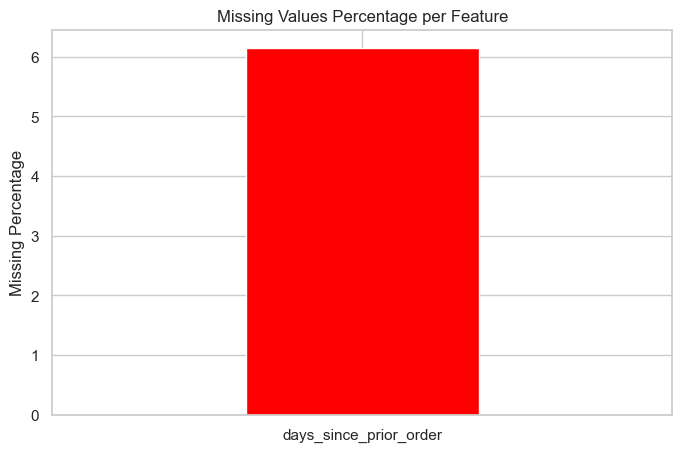

In [173]:
#cheking for null values
missing_values = Full_DataSet.isnull().sum()
missing_values = missing_values[missing_values > 0]
print( missing_values )
print("=="*40 )
missing_percent = (missing_values / len(Full_DataSet)) * 100
print(f"Percentage of missing values in columns\n {missing_percent}", )

missing_percent.plot(kind='bar', figsize=(8, 5), width=0.3, color='red', rot=0)
plt.ylabel("Missing Percentage")
plt.title("Missing Values Percentage per Feature")
plt.show()
# هاي مش قيم مفقوده بالغلط هاي بتدل انه الزبون اول مره بيطلب فمفيش عندو قيمه ل days_since_prior_order

Percentage of missing values in columns
 days_since_prior_order    6.144657
dtype: float64


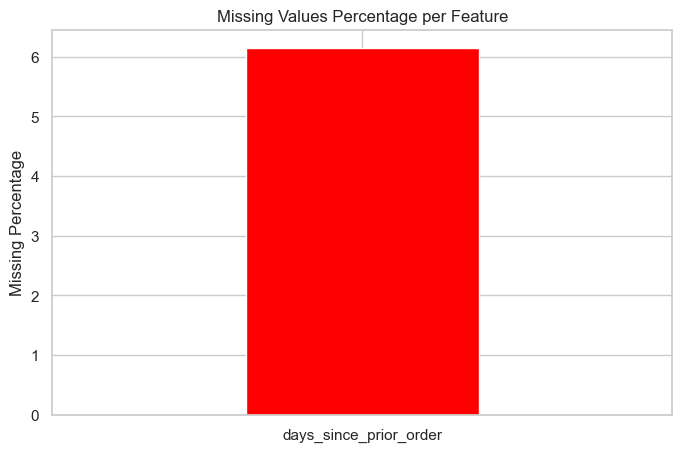

In [174]:
missing_percent = (missing_values / len(Full_DataSet)) * 100
print(f"Percentage of missing values in columns\n {missing_percent}", )

missing_percent.plot(kind='bar', figsize=(8, 5), width=0.3, color='red', rot=0)
plt.ylabel("Missing Percentage")
plt.title("Missing Values Percentage per Feature")
plt.show()
# هاي مش قيم مفقوده بالغلط هاي بتدل انه الزبون اول مره بيطلب فمفيش عندو قيمه ل days_since_prior_order

Percentage of missing values in columns
 days_since_prior_order    6.144657
dtype: float64


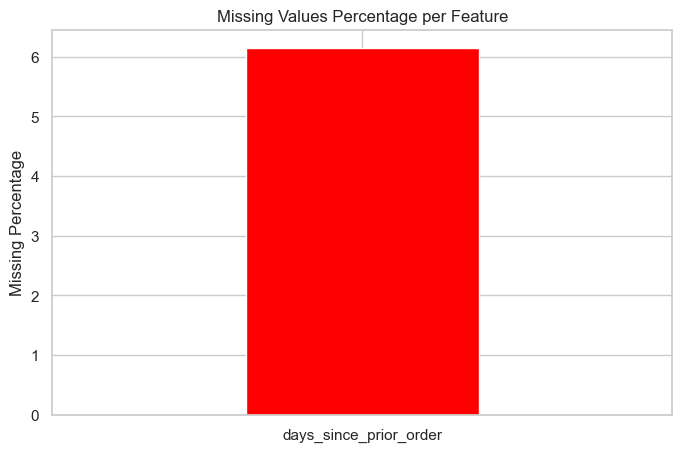

In [175]:
missing_percent = (missing_values / len(Full_DataSet)) * 100
print(f"Percentage of missing values in columns\n {missing_percent}", )

missing_percent.plot(kind='bar', figsize=(8, 5), width=0.3, color='red', rot=0)
plt.ylabel("Missing Percentage")
plt.title("Missing Values Percentage per Feature")
plt.show()
# هاي مش قيم مفقوده بالغلط هاي بتدل انه الزبون اول مره بيطلب فمفيش عندو قيمه ل days_since_prior_order

Distribution plots for numeric features and target(s) (histogram, density).


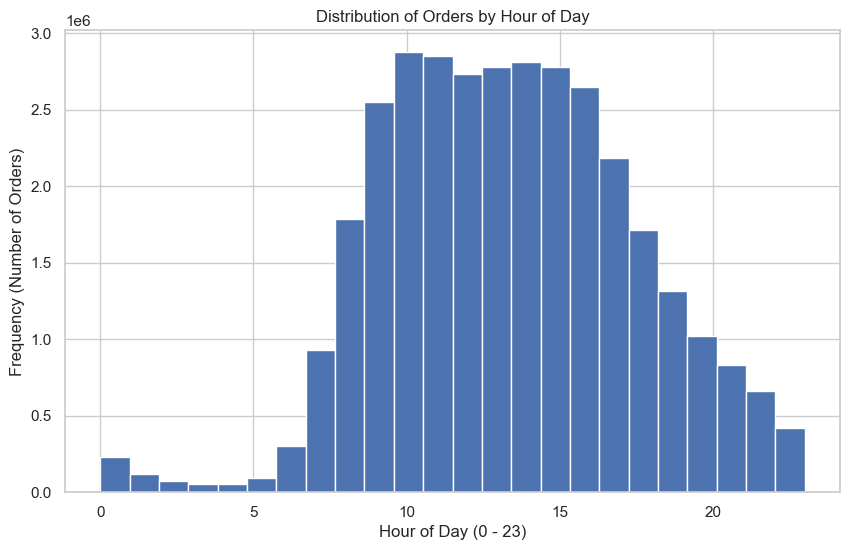

In [176]:
# لازم نختار الاعمده الرقميه الي الها معنى او بتفيدنا لو عملنا الها هستوغرام او دينستي بالاحرى مين مهم افهم الديستربويشن تبعو
Full_DataSet['order_hour_of_day'].plot(kind='hist', bins=24, figsize=(10, 6), title='Distribution of Orders by Hour of Day')

#Histogram (المدرج التكراري) رسمة أعمدة بتبين الكمية في كل فترة

plt.xlabel('Hour of Day (0 - 23)') # سمينا المحور عشان الدكتور يفهم

plt.ylabel('Frequency (Number of Orders)')
plt.show()

#بنلاحظ  فوق الوقت الي بكون فيه وقت الذروه للزباين متى بكون باليوم

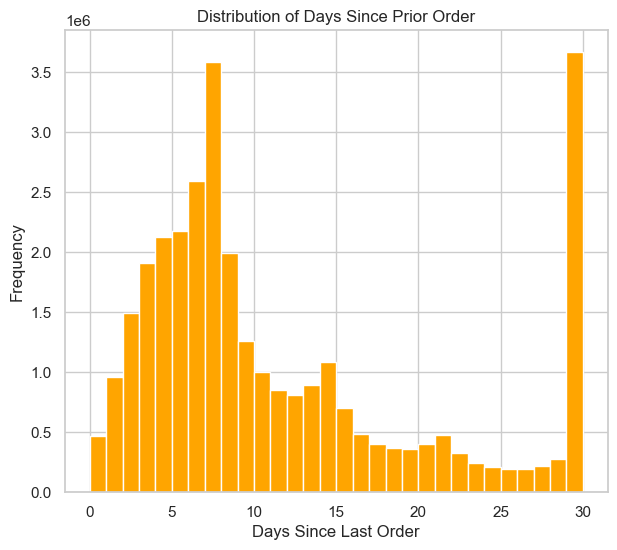

In [177]:
Full_DataSet['days_since_prior_order'].plot(kind='hist', bins=30, figsize=(7, 6), color='orange', title='Distribution of Days Since Prior Order')

plt.xlabel('Days Since Last Order')
plt.ylabel('Frequency')
plt.show()

In [178]:
#Weekly shoppers (peak at 7 days) and Monthly shoppers (peak at 30 days). The spike at 30 days also includes customers who haven't ordered for more than a month

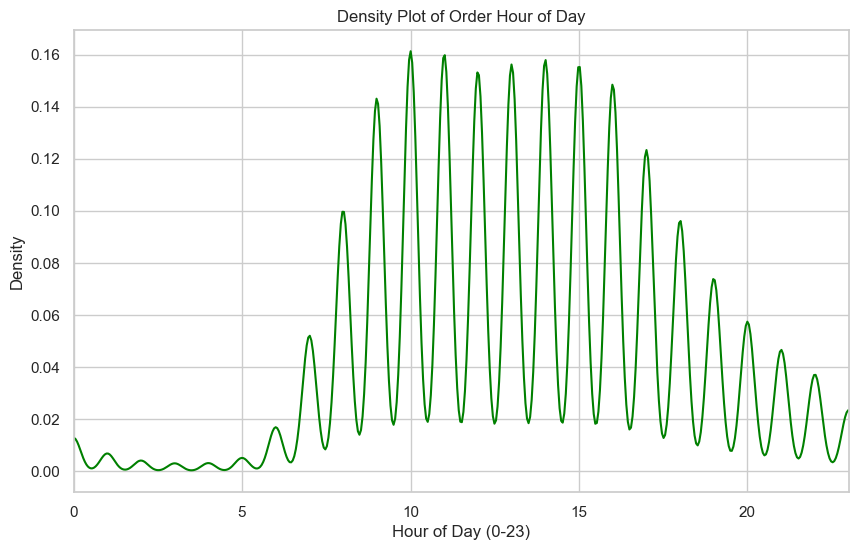

In [179]:
# 1. نأخذ عينة عشوائية (10% مثلاً) عشان الرام ما تنفجر
# هذا العمود يمثل "ساعات اليوم" من 0 لـ 23
sample_hours = Full_DataSet['order_hour_of_day'].sample(frac=0.1, random_state=42)

# 2. الرسم


plt.figure(figsize=(10, 6))

sample_hours.plot(kind='kde', color='green', title='Density Plot of Order Hour of Day')

plt.xlabel('Hour of Day (0-23)')
plt.xlim(0, 23) # عشان نحصر الرسمة في حدود اليوم
plt.show()

#الدينستي بعطينا هون تفاصيل اكثر او معبر اكثر بس بوخذ وقت اكثر للامانه 


Categorical cardinality analysis (barplots / top-k frequencies).

In [180]:
# first we need to do some cardinality checking for the catorgorical features
categorical_cols = Full_DataSet.select_dtypes(include=['category']).columns
categorical_cols



Index(['eval_set', 'product_name', 'department', 'aisle'], dtype='object')

In [181]:
Full_DataSet["product_name"].value_counts() # هون بنلاحظ انو في منتجات كتير متكرره يعني الكارديناليتي عاليه فهاض العامود مابفيدني اعملو فيجواليزشن

product_name
Banana                                             491291
Bag of Organic Bananas                             394930
Organic Strawberries                               275577
Organic Baby Spinach                               251705
Organic Hass Avocado                               220877
                                                    ...  
Brut Prosecco                                           1
7.04 Oz. Grahamfuls Banana Vanilla 8ct                  1
Unpeeled Apricot Halves in Heavy Syrup                  0
Protein Granola Apple Crisp                             0
Single Barrel Kentucky Straight Bourbon Whiskey         0
Name: count, Length: 49688, dtype: int64

In [182]:
# نعمل فحص للباقي
checking = ['department', 'aisle', 'product_name']

cardinality_counts = Full_DataSet[checking].nunique()
print("عدد الأنواع في كل عمود")
print(cardinality_counts)
# هون بنلاحظ الديبراتمنت فيه تنوع واطي فا بنقدر نعملو فيجواليز ونستفيد منه
# الممرات 134 يعتبر عاللي فامبنقدر نرسمو كلو رح نوخذ الاكثر تكرارا تمام نفس الحاله بنطبقها على اسماء المنتجات

عدد الأنواع في كل عمود
department         21
aisle             134
product_name    49685
dtype: int64


In [183]:
# what is eval_set refer to ?
Full_DataSet['eval_set'].value_counts()
# هون شفنا انو هاض العامود بحتوي على داتا بتمثل الطلبات القديمه فهاض الاشي مابفيدني اني اعملو فيجواليز

eval_set
prior    32434489
train     1384617
test            0
Name: count, dtype: int64

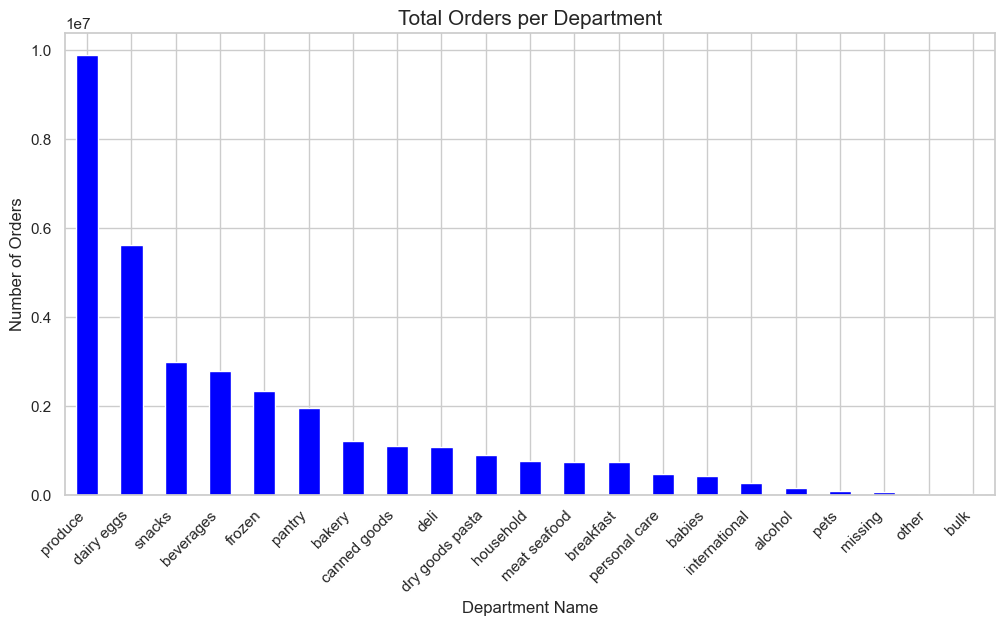

In [184]:


#  بنرسمه كأعمدة Barplot
Full_DataSet['department'].value_counts().plot(kind='bar', figsize=(12,6) , color='blue')

plt.title('Total Orders per Department', fontsize=15)
plt.ylabel('Number of Orders')
plt.xlabel('Department Name')
plt.xticks(rotation=45, ha='right') # ميلنا الأسماء عشان نقرأها بوضوح
plt.show()

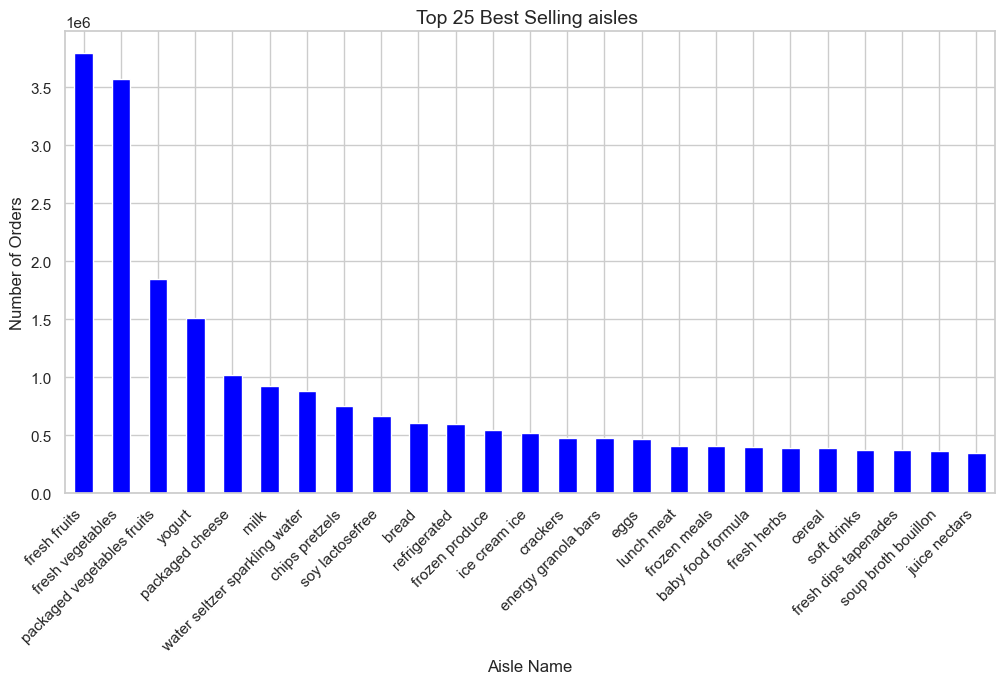

In [185]:
top_aisles = Full_DataSet['aisle'].value_counts().head(25)
#  هون ممكن تسالني انت طيب كيف رتبتهم من الاكثر للاقل ؟ لان الميثود تاعت الفاليوز بالديفولت تاعها بترتبهم من الاكبر لاصغبر

top_aisles.plot(kind='bar',figsize=(12, 6), color='blue')


plt.title('Top 25 Best Selling aisles ', fontsize=14)
plt.ylabel('Number of Orders')
plt.xlabel('Aisle Name')
plt.xticks(rotation=45, ha='right') # ميلنا الكلام بزاوية 45 عشان ينقرأ بوضوح
plt.show()

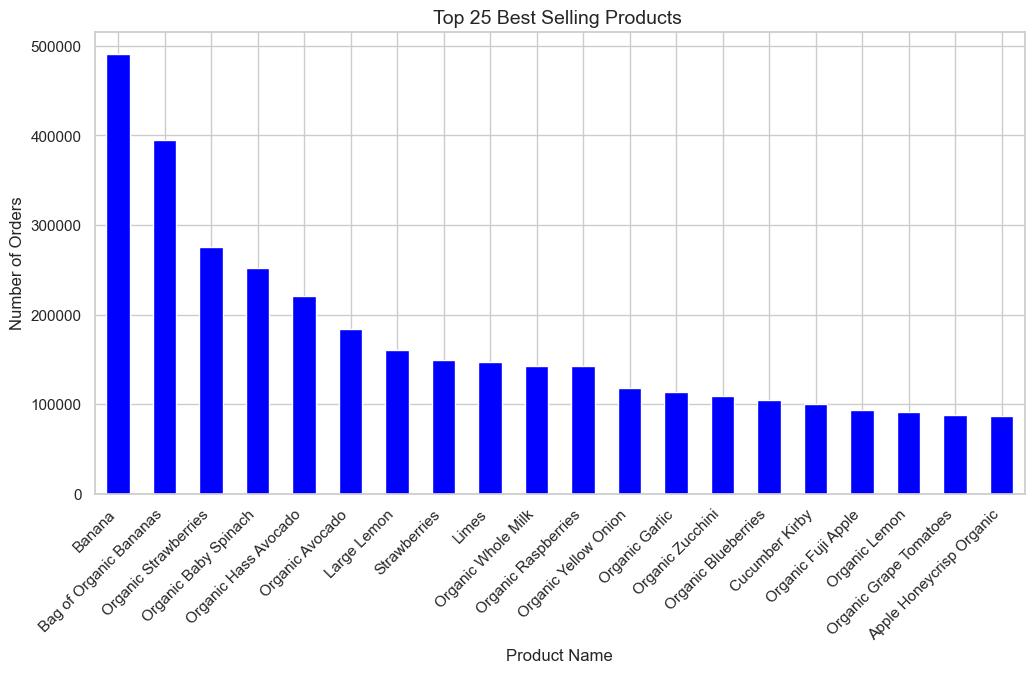

In [186]:
products_for_visuals = Full_DataSet['product_name'].value_counts().head(20) # هون اخذنا اكثر 20 بس عشان يصير مقروء بشكل احسن

products_for_visuals.plot(kind='bar', figsize=(12, 6), color='blue')
plt.title('Top 25 Best Selling Products ', fontsize=14)
plt.ylabel('Number of Orders')
plt.xlabel('Product Name')
plt.xticks(rotation=45, ha='right')
plt.show()

• Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.

In [187]:
#  هاي الخطوة بدنا نعرف شو العوامل اللي بتخلي الزبون يعمل اعادة طلب او reorder
# في هاي الحاله لازم نختار الاعمده الرقميه الي الها سلوك او بمعنى اصح الها معنى

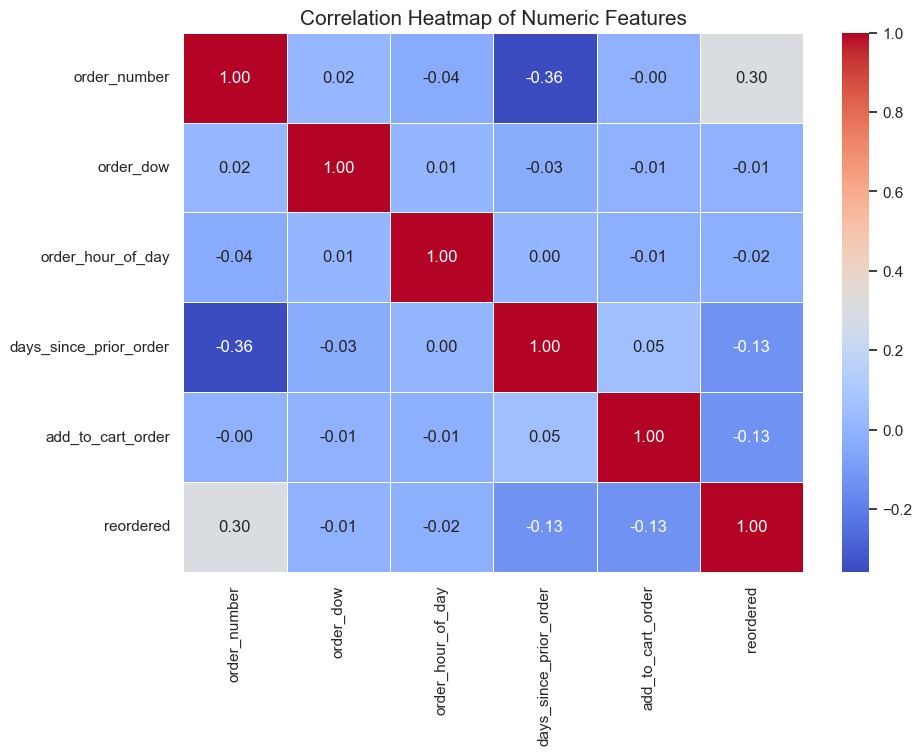

In [188]:
selected_features = [
    'order_number',
    'order_dow',
    'order_hour_of_day',
    'days_since_prior_order',
    'add_to_cart_order',
    'reordered' # هاض العامود الي بدنا نعرف شو العوامل الي بتأثر عليه مثل ماقلنا فوق
]

# 2. حساب المصفوفة (Correlation Matrix)
# الدالة .corr() هي العقل المدبر اللي بيحسب العلاقات
corr_matrix = Full_DataSet[selected_features].corr()


# annot=True: عشان يكتب الرقم جوا المربع
# cmap='coolwarm': ألوان (أحمر للحار/الموجب، أزرق للبارد/السالب)
# fmt='.2f': منزلتين عشريتين بس
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=False)

plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()

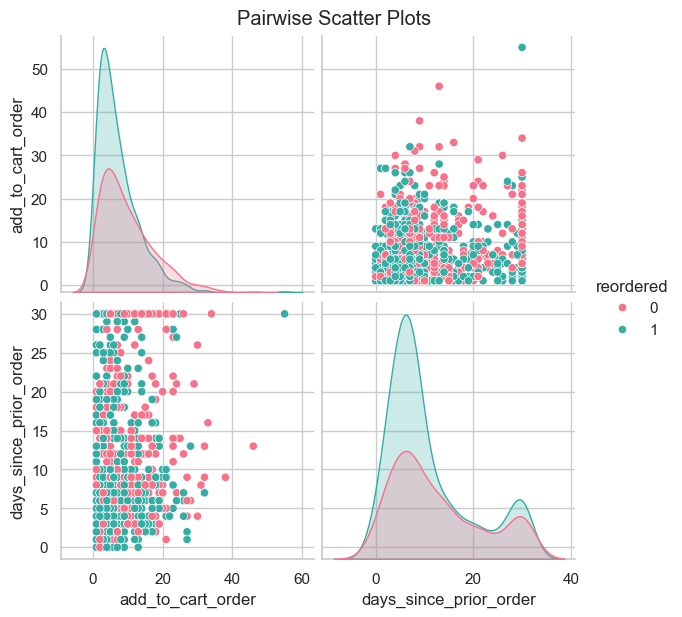

In [189]:
# 1. نأخذ عينة صغيرة جداً (1000 سطر) عشان الرسم يكون خفيف وواضح
# Scatter Plot بيموت لو الداتا كبيرة
scatter_sample = Full_DataSet.sample(n=1000, random_state=42)

# 2. تحديد الأعمدة اللي بدنا نشوف علاقتها ببعض
# ركزنا على أهم 3 أعمدة عشان ما نضيع وقت
cols_to_plot = ['add_to_cart_order', 'days_since_prior_order', 'reordered']

# 3. رسم الـ Pairplot
# hue='reordered': عشان يلون النقاط (برتقالي للمكرر، أزرق للجديد)
sns.pairplot(scatter_sample[cols_to_plot], hue='reordered', palette='husl', height=3)

plt.suptitle('Pairwise Scatter Plots ', y=1.02)
plt.show()


In [190]:
#طيب اللون الاخضر هون بمثل المنتجات المعاد شرائها بنلاحظ بالرسمه انو دايما بالبدايه ببدا الزبون يجيب اغراضو الي  متعود عليها
#بعدين بعد ما يجيبهم بجيب او بجرب اغراض جديده  مثل مابثمل اللون الزهري الي بمثل الاشياء الجديده
#الرسمة الشمال تحت النقط بتوريك إن المنتجات المكررة الخضراء دايما محجوز الها المقاعد الأولى بالسلة  بغض النظر عن كم يوم مر.

# الرسمة اليمين جبال بتأكد إن الناس بتتسوق بنظام أسبوعي أو شهري والمنتجات الجديدة والقديمة بتمشي على نفس هذا النظام.

• Time-of-day, day-of-week, and monthly seasonality plots

In [191]:
hourrr=Full_DataSet['order_hour_of_day'].value_counts()
hourrr

order_hour_of_day
10    2874905
11    2852701
14    2810918
15    2780731
13    2778054
12    2732599
16    2647695
9     2550569
17    2186409
8     1787359
18    1714445
19    1317576
20    1017958
7      928239
21     831183
22     662053
23     419585
6      302642
0      228031
1      121412
5       91909
2       72660
4       55714
3       53759
Name: count, dtype: int64

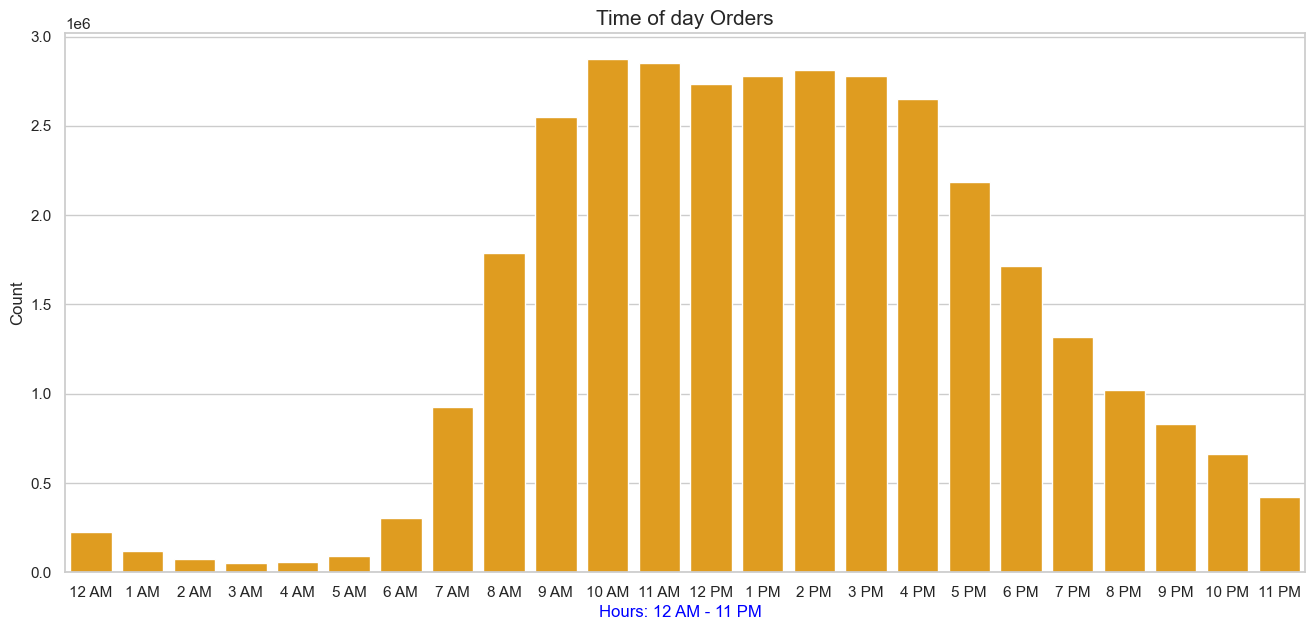

In [192]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 7))


# هون لازم قبل مانرسم نجهز الداتا لانها عباره عن مليون سطر فا لازم نرتبها اول حسب التكرار بعدين بنرتبها حسب الاندكس تصاعدني
hour_counts = Full_DataSet['order_hour_of_day'].value_counts().sort_index()
#لو تركناها هيك لاحظت رح تطلع معنا الرسمه الساعات من صفر ل 23 فا حيكون شوي مش مقروء الوضع فا افترحت لو بدنا نوري هالرسمه لاي حد لو نزبط الاندكس
#ونخليه بنظام am و pm
#بكون احسن ليش فقط عشان نخليه مقروء واريح للعين اكثر
labels_of_hours = [
    "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM",
    "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
    "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM",
    "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
]
# x=labels_of_hours (الساعات)
# y=hour_counts.values (عدد الطلبات)
#هون اخترنا بار بلوت عشان سريع وبرضو برسملنا ال 24 عمود بسرعه عاليه
sns.barplot(x=labels_of_hours, y=hour_counts.values, color='orange',)

plt.title('Time of day Orders', fontsize=15)
plt.xlabel('Hours: 12 AM - 11 PM  ', fontsize=12,color='blue')
plt.ylabel('Count', fontsize=12)
plt.show()

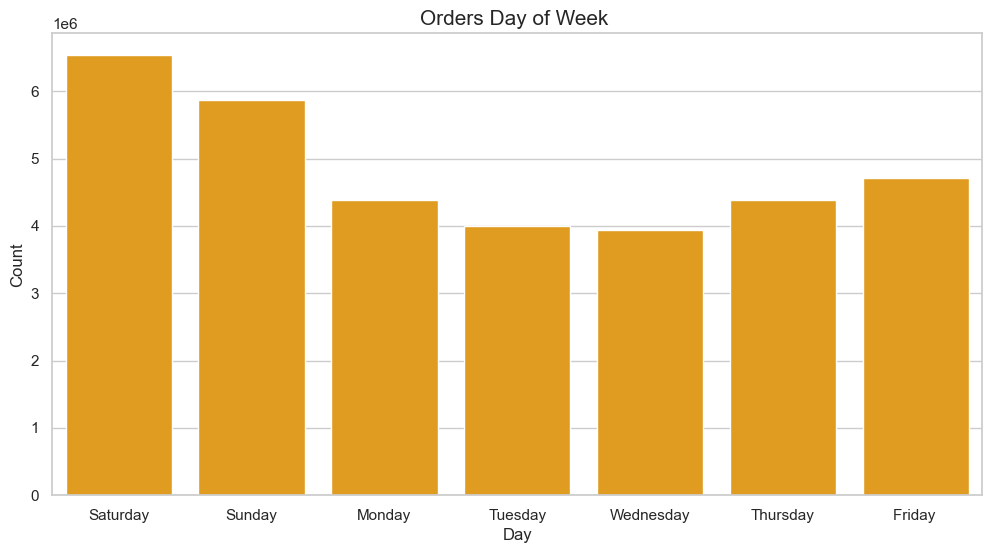

In [193]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# رح يطلع معنا 7 أرقام من 0 ـ 6
day_counts = Full_DataSet['order_dow'].value_counts().sort_index()

#بنرتبهم كمان مره زي ماعملنا فوق
 # الويك إند عند الاجانب ببدا من السبت فهو رح يكون رقم صفر
days_labels = ["Saturday",  "Sunday", "Monday",  "Tuesday", "Wednesday", "Thursday","Friday "]



sns.barplot(x=days_labels, y=day_counts.values, color="orange")

plt.title('Orders Day of Week ', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)

plt.show()
#بنلاحظ انو بالويكند اعلى طلبات وهاض المنطقي لانو الناس بتكون معطله

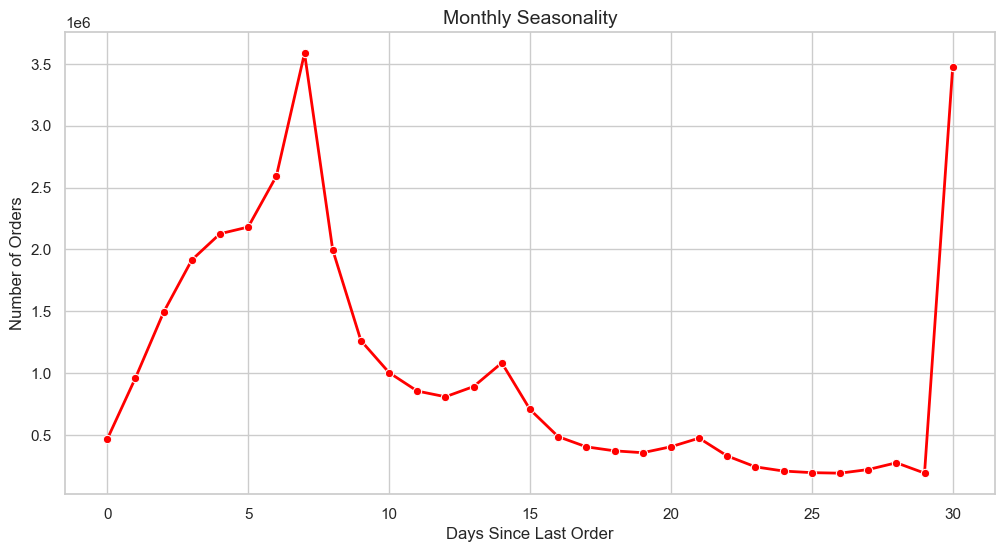

In [194]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

#  هون رح نستخدم هاض الكولوم لانو انسب اشي للمنثلي لانو مافي عنا بالداتا سيت كولم عن الاشهر
days_of_month_counts = Full_DataSet['days_since_prior_order'].value_counts().sort_index()
#رح نستخدم اللاين بلوت عشان نوضح التغيرات بشكل افضل
sns.lineplot(x=days_of_month_counts.index, y=days_of_month_counts.values, marker='o', color='red', linewidth=2)

# 3. تحسين المحاور
plt.title('Monthly Seasonality', fontsize=14)
plt.xlabel('Days Since Last Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()
#بنلاحظ في قمه عند ال 7 و 30 يوم هاض يعني انو الزبون كل اسبوع غالبا بيجي يشتري وفي زباين بتيجي كل شهر او اكثر من شهر هاض كلو بنحط عند ال 30

3: outliers cleaning


In [195]:
#هذول حذفتهم لانه ما في منهم  داعي , رح استخدم ال id بس
del Full_DataSet["aisle"]
del Full_DataSet["department"]

print(Full_DataSet.isnull().sum())
print("---------------------------------------")

#كان هدفي اشوف ال نان من هون بس ما زبطت ف شفتها من الملف نفسه
Full_DataSet.head(10)
#اللي بين معي انه ال نان بكون موجود لكل اول اوردير بطلبه المستخدم\الزبون

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
dtype: int64
---------------------------------------


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16


In [196]:
def check_outliers(Full_DataSet):
    #هذول الاعمده الرقميات اللي ما بدي افحصهم , لانه اكيد مش رح يكون فيهم اوتلير
    out = ["order_id" , "product_id" , "user_id" , "aisle_id" , "department_id" , "eval_set"]

    #بصفي الاعمده الرقميه كلها
    Outliers_DF = []
    numeric_cols_all = Full_DataSet.select_dtypes(include=[np.number]).columns.tolist()

    #بشيل الاعمده اللي ما بدي افحصهم(اللي حددتهم فوق) واللي مش موجود فيها بدخلصه عالليست
    for i in numeric_cols_all:
        if i not in out:
            Outliers_DF.append(i)
 
    #هون بحدد عدد الصفوف والاعمده لل subplot عشان يطلع شكلو مرتب
    col_length = len(Outliers_DF)
    row = (col_length // 3) + 1
    plt.figure(figsize=(20 , 5 * row))

    #هاي بتعطيك ال index و value 
    for i , col in enumerate(Outliers_DF):
        plt.subplot(row , 3 , i + 1)

        plot_data = Full_DataSet[col].dropna().sample(n = min(100000 , len(Full_DataSet)))

        sb.boxplot(x = plot_data , color="lightblue")
        plt.title(col , fontsize = 12)
        plt.xlabel(" ")

    plt.tight_layout()
    plt.show()

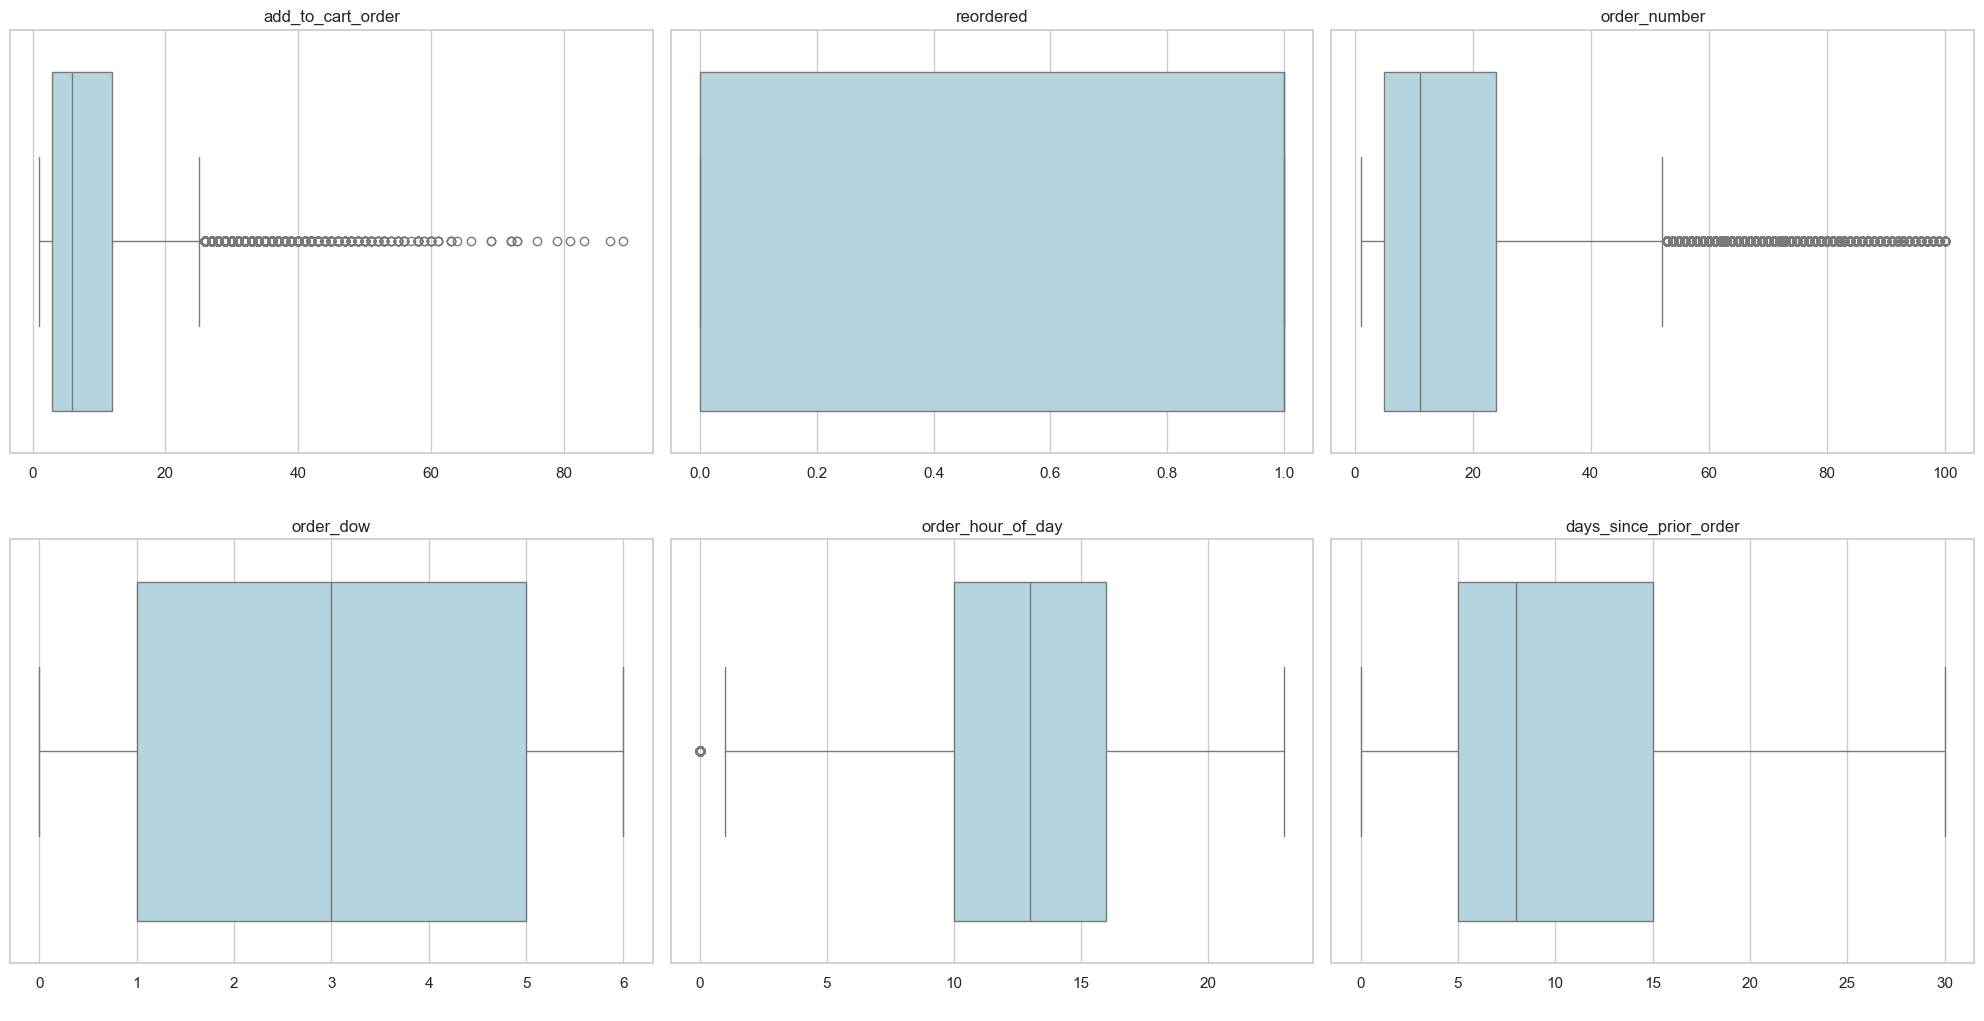

None
count    3.381911e+07
mean     8.262399e+00
std      6.694448e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.100000e+01
max      3.000000e+01
Name: add_to_cart_order, dtype: float64

count    3.381911e+07
mean     1.612121e+01
std      1.452498e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.100000e+01
75%      2.400000e+01
max      5.000000e+01
Name: order_number, dtype: float64


In [197]:
print(check_outliers(Full_DataSet))

#من خلال الرسم بين معي انه الحد الفاصل بين اكبر قيمه والاوتلايرز هي 30
Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 30 , 30 , Full_DataSet["add_to_cart_order"])
#ونفس المبدأ بنطبق هون
Full_DataSet["order_number"] =  np.where(Full_DataSet["order_number"] > 50 , 50 , Full_DataSet["order_number"])

print(Full_DataSet["add_to_cart_order"].describe())
print()
print(Full_DataSet["order_number"].describe())



4: feature engineering (mandatory list)

In [198]:
#اللي كنا عاملينه قبل انه ما استخدمنها ال بريور بالهندسه , كنا ناسيين ما نضيفه للداتا فريم الكامله  اثناء الدمج

#هاي اللي بدي اعمل هندسه الميزات بناءا عليها , لانها بتحتوي على السجل الماضي لطلبات المستخدمين , مهم استخدامها بالذات عشان ابعد عن تسريب البيانات
prior_df = Full_DataSet[Full_DataSet["eval_set"] == "prior"].copy()
#هاي اللي بدي استخدمها بتقسيم البيانات , اشي منها تدريب والباقي اختبار , وهي بتمثل الطلبات الاخيره للمستخدمين
train_df = Full_DataSet[Full_DataSet["eval_set"] == "train"].copy()

In [199]:
#total orders per user يعني كل مستخدم كم مره فات المحل واشترى يعني كم طلب عملو بشكل كامل مش كم منتج اشتراه بحياتو
# طيب هون القروب باي بيجمعلي كل الداتا تبع كل يوزر ايدي لحال
#بعدين بقله لكل يوزر بدي كولوم الاوردر نمبر تمام هسا الاورودر نمبر لكل زبون بمثل كل زبون كم طلب عملو لحد الان فا لو اخذتلو ال ماكس
#لو اخذت الماكس رح تعطيني رقم اخر فاتوره والي بمثل عدد الطلبات الكلي لكل زبون طيب ممكن تسالني كان بمكاني اختار كاونت مش ماكس صح كلامك لكن
#الداتا الي عندي او كولوم الاوردر نمبر يعني بحتوي على ارقام الطلبات مش عدد الطلبات فلو اخذت كاونت رح يطلعلي عدد المنتجات مش عدد الطلباتؤ
#استخدمنا الريست اندكس عشان يرجعلي الداتا فريم مش سيرييز لانو قروب باي بيرجع سيرييز افتراضيا وبتخرب الداتا بصير اليوزر هو كولوم الاندكس
user_total_orders = prior_df.groupby('user_id')['order_number'].max().reset_index()
# 3. بنسمي العمود اسم واضح عشان ما نتخربط بعدين
user_total_orders.columns = ['user_id', 'user_total_orders']

print(user_total_orders.head())

   user_id  user_total_orders
0        1                 10
1        2                 14
2        3                 12
3        4                  5
4        5                  4


In [200]:
#  average basket size
#هذه الميزة بتحدد القدرة الشرائية Purchasing Power
#وبتحدد نمط التسوق عند الزبون يعني بعرف الزبون الي عادته يشتري مثلا 50 غرض هاض زبون بمتوسط سلة كبيرة فا بهمني انو المودل ممكن
#بهمني انو المودل ممكن يشوف هالشي ويستفيد منه بحيث لو كان شاري 3 اغراض بس يضل يقترح عليه لانو هالزبون من عادتو يشتري كثير

#============================================================================================================

#طيب السواال كيف بنحسبها ؟ بنحسبها عن طريق انو بنجيب لكل زبون كم المنتجات الي اشتراها بشكل كلي
#بعدين بنجيب كم طلب عملو بشكل كلي
#بعدين بنقسم المجموع على العدد
#============================================================================================================
#هون اولا عشان نجيب مجموع المنتجات الي اشتراها كل زبون بنجيب كولوم البروودكت ايدي وبنعمللو كاونت هيك بنعد كل المنتجات الي اشتراها
#بعدين بنجيب كولوم الاوردر نمبر وبناخد الماكس زي ما شرحنا فوق عشان نعرف كم طلب عملو بشكل كلي

#واستخدمنا ميثود الاقريقيت الي بتتيحلي اعمل اكشنز متعدده على كولمز مختلفه بنفس الوقت بدل ما اعمل قروب باي مرتين
basket_data = prior_df.groupby('user_id').agg({ 'product_id':'count', 'order_number': 'max'}).reset_index()

# مجرد تسميت الكولمز بشكل واضح بس
basket_data.columns = ['user_id', 'total_items_bought', 'total_orders_made']

#الحسبه
basket_data['avg_basket_size'] = basket_data['total_items_bought'] / basket_data['total_orders_made']

print(basket_data.head())

   user_id  total_items_bought  total_orders_made  avg_basket_size
0        1                  59                 10         5.900000
1        2                 195                 14        13.928571
2        3                  88                 12         7.333333
3        4                  18                  5         3.600000
4        5                  37                  4         9.250000


In [201]:
#  User-Level Features full
#هون لازم نعمل سورت اول عشان اخر مطلوب اللاست لاخر طلب فا ممكن يكون اخر طلب الي بجيبو مش هو اخر طلب عملو
#بس الجهاز عندي بتحملش
prior_df.sort_values(['user_id', 'order_number'], inplace=True)
user_features = prior_df.groupby('user_id').agg({
      # 1. Total #Orders
    'order_number': 'max',
    # 2. هاض بساعدنا نعرف كم منتج اشتراها كل زبون بشكل كلي
     'product_id': 'count',
    # 3. Reorder Ratio
    'reordered': 'mean',

   #هون حسبنا اخر مطلوبين بخطوه وحده بدل ما نعمل قروب باي مرتين
    'days_since_prior_order': ['mean', 'last']
}).reset_index()


user_features.columns = ['user_id',  'user_total_orders',  'user_total_items', 'user_reorder_ratio','user_avg_days_between', 'user_days_since_last_order'  ]

# Basket Size
user_features['user_avg_basket_size'] = user_features['user_total_items'] / user_features['user_total_orders']

#هاض العامود مش ضروري بعد ما حسبنا الافريج مابنحتاجه
del user_features['user_total_items']

display(user_features.head())



,user_id,user_total_orders,user_reorder_ratio,user_avg_days_between,user_days_since_last_order,user_avg_basket_size
0,1,10,0.694915,20.259260,30.0,5.900000
1,2,14,0.476923,15.967033,13.0,13.928571
2,3,12,0.625000,11.487180,15.0,7.333333
3,4,5,0.055556,15.357142,0.0,3.600000
4,5,4,0.378378,14.500000,19.0,9.250000


Product-level features

In [202]:
# --- Product-Level Features ---

# هالمره التجميع رح يكون حسب المنتج مش حسب اليوزر
product_features = prior_df.groupby('product_id').agg({

    #  Popularity
    #هون شو ممكن يفيدنا هون قصدو من البوبولاريتي انه نعرف كم مرة انباع هاد المنتج ممكن من خلاله نعرف  اكثر المنتجات بينباع او وين اقل منتج
    'user_id': 'count',
    # ليش user_id؟ وليش count؟
    # عشان نعد كم زبون اشترى هاد المنتج لانو كل سطر بيمثل  عنا عمليه شراء.
    #====================================================================================
    #  Reorder Rate
    #هون بنحسب نسبة اعادة الطلبات للمنتج
    'reordered': 'mean',
    #هاي واضحه من اسمها بدهاش اشي
    #====================================================================================
    # Average  Position
    #طيب ممكن تسالني ليش اخترنا هاض الكولوم بالذات رح لانه بمثل ترتيب المنتج داخل السلة فلو اخذنا المين رح يعطينا ترتيب المنتج داخل السلة زي ماهو طالب
    'add_to_cart_order': 'mean'

}).reset_index()

product_features.columns = [ 'product_id', 'product_total_purchases', 'product_reorder_rate', 'product_avg_cart_position' ]

display(product_features.head())

,product_id,product_total_purchases,product_reorder_rate,product_avg_cart_position
0,1,1852,0.613391,5.739741
1,2,90,0.133333,9.677778
2,3,277,0.732852,6.321300
3,4,329,0.446809,9.468085
4,5,15,0.600000,6.466667


User×Product interaction features

In [203]:
#UserxProduct Interaction Features
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

uxp_features = (
    prior_df
    .groupby(['user_id', 'product_id'])
    .agg({
        'reordered': ['count', 'mean'],
        'days_since_prior_order': 'max'
    })
    .reset_index()
)

uxp_features.columns = [
    'user_id',
    'product_id',
    'uxp_total_bought',
    'uxp_reorder_ratio',
    'uxp_days_last_order'
]

display(uxp_features.head(20))


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_days_last_order
0,1,196,10,0.900000,30.0
1,1,10258,9,0.888889,30.0
2,1,10326,1,0.000000,28.0
3,1,12427,10,0.900000,30.0
4,1,13032,3,0.666667,30.0
5,1,13176,2,0.500000,28.0
6,1,14084,1,0.000000,NaN
7,1,17122,1,0.000000,28.0
8,1,25133,8,0.875000,30.0
9,1,26088,2,0.500000,15.0


Temporal features: hour/day/month/year, season, holiday flags (if available).

In [204]:
# طيب هون المطلوب منا بالتيمبورال فيشترز انو نزبط الوقت مثلا نخليه صبح ومسا ومثلا الايام نقسمها ايام عاديه وايام عطله والشهر
#بس مبادايا الشهر والسنه والموسم مابنقدر لانو مامعنا معلومات عنها  في رح نكتفي بالساعات واليوم
#نبدا بالساعات هسا التوقيت  عنا من 0 ل 23 فممكن نقسمهم لثلاث فترات
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Midnight'
prior_df['time_of_day'] = prior_df['order_hour_of_day'].apply(time_of_day)
print(prior_df['time_of_day'].head(10))
print("=="*40)
#طيب قلنا للايام بنقسمها لايام عاديه وايام عطله
#وزي مابنعرف بالداتا الي عندي السبت والاحد همه العطله فرقمهم بكون 0 و 1
#هون اختصارا على حالنا لقدام خليت الكولوم الجديد عباره عن ارقام 0 و 1 بدل ما اخليها نصوص عشان اسهل التعامل معها بعدين
def day_type(day):
    if (day == 0) or (day == 1):
        return 1 # طبعا واحد بتعني انها شسمو ويكند
    else:
        return 0
prior_df['is_weekend'] = prior_df['order_dow'].apply(day_type)
print(prior_df['is_weekend'].head(30))
#حطيت 30 لانو خفت كلها صفار ههههه يسعد ربك

24076664    Morning
24076665    Morning
24076666    Morning
24076667    Morning
24076668    Morning
22742744    Morning
22742745    Morning
22742746    Morning
22742747    Morning
22742748    Morning
Name: time_of_day, dtype: object
24076664    0
24076665    0
24076666    0
24076667    0
24076668    0
22742744    0
22742745    0
22742746    0
22742747    0
22742748    0
22742749    0
4488095     0
4488096     0
4488097     0
4488098     0
4488099     0
21376074    0
21376075    0
21376076    0
21376077    0
21376078    0
4089398     0
4089399     0
4089400     0
4089401     0
4089402     0
4089403     0
4089404     0
4089405     0
31927070    0
Name: is_weekend, dtype: int64


In [205]:
# --- 5. Aggregations over Windows (Last 3 Orders) - بدون Lambda ---

# 1. تجهيز الداتا: بنحسب حجم السلة لكل طلب (جدول صغير وخفيف)
orders_summary = prior_df.groupby(['user_id', 'order_number']).size().reset_index(name='basket_size')

# 2. الترتيب (مهم جداً): عشان لما نقول "آخر 3" يكونوا عنجد آخر 3 زمنياً
orders_summary = orders_summary.sort_values(['user_id', 'order_number'])

# 3. تعريف الفنكشن العادي (بدل اللمدا)
# هذا الفنكشن بياخذ عمود أرقام، وبحسب المتوسط المتحرك لآخر 3 قيم
def calculate_last_3_avg(series):
    # window=3: يعني خذ 3 قيم
    # min_periods=1: يعني حتى لو الزبون عنده طلب واحد بس، احسبله المعدل (ما ترجع Null)
    return series.rolling(window=3, min_periods=1).mean()

# 4. تطبيق الفنكشن على كل زبون
# transform: بتمسك الفنكشن اللي كتبناه فوق، وبتطبقه على كل "مجموعة" (زبون)
orders_summary['rolling_avg_3_orders'] = orders_summary.groupby('user_id')['basket_size'].transform(calculate_last_3_avg)

# 5. النتيجة النهائية
# احنا بهمنا "آخر وضع" وصله الزبون، فبناخذ آخر سطر لكل زبون
user_window_features = orders_summary.groupby('user_id').last().reset_index()

# ترتيب وتنظيف الجدول النهائي
user_window_features = user_window_features[['user_id', 'rolling_avg_3_orders']]
user_window_features.columns = ['user_id', 'u_avg_basket_last_3']

display(user_window_features.head(20))

,user_id,u_avg_basket_last_3
0,1,7.000000
1,2,14.666667
2,3,5.666667
3,4,4.000000
4,5,8.666667
5,6,4.666667
6,7,10.000000
7,8,16.333333
8,9,25.333333
9,10,30.666667


✅ تم حساب (Rolling Window) باستخدام فنكشن عادي!

At least one engineered non-linear feature : log transforms

In [206]:
# افترض إنك حسبت user_features في الخطوة الأولى
# بدنا نحول عمود "عدد الطلبات" باستخدام اللوغاريتم
#هسا
print("=")
#هون طقعت ديسبلاي لانها اوضح بس من برنت
user_features['u_total_orders_log'] = np.log(user_features['user_total_orders'])

# حطيناهم جمب بعض عشان تشوف الفرق
print("user_total_orders trasform")
display(user_features[['user_total_orders', 'u_total_orders_log']].head(90))
#
#كمان فيتشر ثاني نعملو مش غلط
product_features['p_total_purchases_log'] = np.log(product_features['product_total_purchases'])

print("="*40)
print("product_ total_purchases transform")

display(product_features[['product_total_purchases', 'p_total_purchases_log']].head())

=
user_total_orders trasform


,user_total_orders,u_total_orders_log
0,10,2.302585
1,14,2.639057
2,12,2.484907
3,5,1.609438
4,4,1.386294
...,...,...
85,17,2.833213
86,27,3.295837
87,7,1.945910
88,20,2.995732


product_ total_purchases transform


,product_total_purchases,p_total_purchases_log
0,1852,7.524021
1,90,4.499810
2,277,5.624018
3,329,5.796058
4,15,2.708050


In [207]:
user_features['u_total_orders_log'] = np.log1p(user_features['user_total_orders'])
product_features['p_total_purchases_log'] = np.log1p(product_features['product_total_purchases'])

#بدي اسوي نسخه للاحتياط , هسا انا صرت بمرحله حرجه شوي و اي خطأ ممكن يدمر الداتا كامله ف الاحتياط واجب
final_df = prior_df.copy()

final_df = final_df.merge(user_features , on = 'user_id' , how = 'left')
#لاني دمجتهم من قبل , عملت هالحركه عشان اتأكد ما يصير عندي اي تكرار
final_df = final_df.drop(columns=[col for col in user_features.columns if col in final_df.columns and col != 'user_id'])

final_df = final_df.merge(user_features , on = 'user_id' , how = 'left')
final_df = final_df.merge(product_features , on = 'product_id' , how = 'left')
final_df = final_df.merge(uxp_features , on = ['user_id' , 'product_id'] , how = 'left')
final_df = final_df.merge(user_window_features , on = 'user_id' , how = 'left')

In [208]:
print(final_df.shape)
print(prior_df.shape)
print()
print(final_df.isnull().sum())
final_df.head()

(32434489, 29)
(32434489, 15)

order_id                            0
product_id                          0
add_to_cart_order                   0
reordered                           0
user_id                             0
eval_set                            0
order_number                        0
order_dow                           0
order_hour_of_day                   0
days_since_prior_order        2078068
product_name                        0
aisle_id                            0
department_id                       0
time_of_day                         0
is_weekend                          0
user_total_orders                   0
user_reorder_ratio                  0
user_avg_days_between               0
user_days_since_last_order          0
user_avg_basket_size                0
u_total_orders_log                  0
product_total_purchases             0
product_reorder_rate                0
product_avg_cart_position           0
p_total_purchases_log               0
uxp_total_bought   

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,user_avg_basket_size,u_total_orders_log,product_total_purchases,product_reorder_rate,product_avg_cart_position,p_total_purchases_log,uxp_total_bought,uxp_reorder_ratio,uxp_days_last_order,u_avg_basket_last_3
0,2539329,196,1,0,1,prior,1,2,8,NaN,...,5.9,2.397895,35791,0.776480,3.705652,10.485480,10,0.9,30.0,7.0
1,2539329,14084,2,0,1,prior,1,2,8,NaN,...,5.9,2.397895,15935,0.810982,5.770003,9.676336,1,0.0,NaN,7.0
2,2539329,12427,3,0,1,prior,1,2,8,NaN,...,5.9,2.397895,6476,0.740735,4.731624,8.776013,10,0.9,30.0,7.0
3,2539329,26088,4,0,1,prior,1,2,8,NaN,...,5.9,2.397895,2523,0.539041,6.472850,7.833600,2,0.5,15.0,7.0
4,2539329,26405,5,0,1,prior,1,2,8,NaN,...,5.9,2.397895,1214,0.441516,3.116969,7.102499,2,0.5,29.0,7.0


In [209]:
#بدي اختار الاعمده اللي لازم ازبط الميموري الهم
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 29 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   product_id                  int32   
 2   add_to_cart_order           int32   
 3   reordered                   int32   
 4   user_id                     int32   
 5   eval_set                    category
 6   order_number                int32   
 7   order_dow                   int32   
 8   order_hour_of_day           int32   
 9   days_since_prior_order      float32 
 10  product_name                category
 11  aisle_id                    int32   
 12  department_id               int32   
 13  time_of_day                 object  
 14  is_weekend                  int64   
 15  user_total_orders           int32   
 16  user_reorder_ratio          float64 
 17  user_avg_days_between       float32 
 18  user_days_since_last_order  float32 
 19

In [210]:
col_name = ["uxp_reorder_ratio" , "u_avg_basket_last_3" , "uxp_total_bought" , "p_total_purchases_log" , "product_avg_cart_position" , "product_reorder_rate" , "product_total_purchases" , "u_total_orders_log" , "user_avg_basket_size" , "user_reorder_ratio" , "is_weekend" , "time_of_day"]

final_df[col_name] = reduce_memory(final_df[col_name])
final_df.info()

C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("float32")
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("float32")
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 29 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   product_id                  int32   
 2   add_to_cart_order           int32   
 3   reordered                   int32   
 4   user_id                     int32   
 5   eval_set                    category
 6   order_number                int32   
 7   order_dow                   int32   
 8   order_hour_of_day           int32   
 9   days_since_prior_order      float32 
 10  product_name                category
 11  aisle_id                    int32   
 12  department_id               int32   
 13  time_of_day                 category
 14  is_weekend                  int32   
 15  user_total_orders           int32   
 16  user_reorder_ratio          float32 
 17  user_avg_days_between       float32 
 18  user_days_since_last_order  float32 
 19

5: NaN cleaning

In [211]:
zero_cols = [
    'uxp_total_bought' ,
    'uxp_reorder_ratio' ,
    'days_since_prior_order' ,
    'uxp_avg_days_between' ,
    'uxp_last_order_num' ,
    'days_since_prior_order' , 
    'uxp_days_last_order'
]

median_cols = [
    'product_total_purchases' ,
    'product_reorder_rate' ,
    'product_avg_cart_position' ,                    
    'p_total_purchases_log'
]

valid_zero_cols = [c for c in zero_cols if c in final_df.columns]
valid_median_cols = [c for c in median_cols if c in final_df.columns]

# 2. تطبيق Imputation
print("Imputing Zero Values...")
final_df[valid_zero_cols] = SimpleImputer(
    strategy='constant',
    fill_value=0
).fit_transform(final_df[valid_zero_cols])

print("Imputing Median Values...")
final_df[valid_median_cols] = SimpleImputer(
    strategy='median'
).fit_transform(final_df[valid_median_cols])

print("Done.")


Imputing Zero Values...
Imputing Median Values...
Done.


In [212]:
final_df = final_df.drop(columns=['user_days_since_last_order_x' ,
                                  'user_days_since_last_order_y'] ,
    errors='ignore'
)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 29 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   product_id                  int32   
 2   add_to_cart_order           int32   
 3   reordered                   int32   
 4   user_id                     int32   
 5   eval_set                    category
 6   order_number                int32   
 7   order_dow                   int32   
 8   order_hour_of_day           int32   
 9   days_since_prior_order      float64 
 10  product_name                category
 11  aisle_id                    int32   
 12  department_id               int32   
 13  time_of_day                 category
 14  is_weekend                  int32   
 15  user_total_orders           int32   
 16  user_reorder_ratio          float32 
 17  user_avg_days_between       float32 
 18  user_days_since_last_order  float32 
 19

In [213]:
#final_df.to_csv('archive/new_instacart_data.csv', index=False)
final_df.isnull().sum()

order_id                      0
product_id                    0
add_to_cart_order             0
reordered                     0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order        0
product_name                  0
aisle_id                      0
department_id                 0
time_of_day                   0
is_weekend                    0
user_total_orders             0
user_reorder_ratio            0
user_avg_days_between         0
user_days_since_last_order    0
user_avg_basket_size          0
u_total_orders_log            0
product_total_purchases       0
product_reorder_rate          0
product_avg_cart_position     0
p_total_purchases_log         0
uxp_total_bought              0
uxp_reorder_ratio             0
uxp_days_last_order           0
u_avg_basket_last_3           0
dtype: int64

6: Dimensionality & collinearity

In [214]:
col_name = ["aisle_id" , "product_id" , "uxp_total_bought" , "p_total_purchases_log" , "days_since_prior_order" , "product_reorder_rate" , "product_avg_cart_position" , "uxp_days_last_order" , "user_id" , "uxp_reorder_ratio" , "product_total_purchases" ]

final_df[col_name] = reduce_memory(final_df[col_name])
final_df.info()

C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("int32")
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("int32")
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 29 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   product_id                  int32   
 2   add_to_cart_order           int32   
 3   reordered                   int32   
 4   user_id                     int32   
 5   eval_set                    category
 6   order_number                int32   
 7   order_dow                   int32   
 8   order_hour_of_day           int32   
 9   days_since_prior_order      float32 
 10  product_name                category
 11  aisle_id                    int32   
 12  department_id               int32   
 13  time_of_day                 category
 14  is_weekend                  int32   
 15  user_total_orders           int32   
 16  user_reorder_ratio          float32 
 17  user_avg_days_between       float32 
 18  user_days_since_last_order  float32 
 19

In [215]:
#هون بلشت اجهز البيانات للانكوديرز والتدريب , صنفتهم حسب المطاليب

id_cols = ['order_id' , 'user_id' , 'product_id' , 'aisle_id' , 'department_id']
low_cols = ["department_id" , "order_dow" , "time_of_day"]
high_cols = ["user_id" , "product_id" , "aisle_id"]

final_df[high_cols] = final_df[high_cols].astype(str)
#هالحركه سويتها بعد ما متت وانا بحلل الكود بعد ما طلعلي التنبيه هاض
#Warning: No categorical columns found. Calling 'transform' will only return input data.
#لما راجعت الانكوديرز تذكرت انه التارقيت ما بشتغل غير مع نصوص والاعمده اللي انا معطيه اياهم رقميات

target_col = "reordered"
Frequency_col = "product_name"

#عدد الاعمده كبير جدا فقلت بعمل لوب + استثناءات عشان اريح راسي

#جبت كل الاعمده الرقميه باستثناء التارقيت وحطيتهم داخل ليست
num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32" , "float32"]).columns.tolist())
#اما السطر هاض عباره عن تصفيه نهائيه , بشيل اعمده ال id لانها ما بتفيدنا ابدا بالتحليل وما بدي احول منها اشي
num_cols = [c for c in num_cols if c not in id_cols]

In [216]:
#بدي استخدم VIF , هاض عباره عن فنكشن رياضي ببين قديش في ارتباط وتكرار بين الاعمده نفسهم
#الهدف منه اني اشوف شو في اعمده فيهم تشابه كبير وبقدمو نفس المعلومه تقريبا عشان احذف واحد منهم

SAMPLE_SIZE = 50000
V = final_df[num_cols].sample(n = SAMPLE_SIZE , random_state = 42)

vif = pd.DataFrame()
vif["feature"] = V[num_cols].columns
vif["VIF"] = [variance_inflation_factor(V.values , i) for i in range(V.shape[1])]

#تحت 5 ممتاز
#بين ال 6 وال 10 مقبول
#اكثر من هيك بدك تشوف شو و وين في ترابط غير مهم وتبلش تحذف

vif.sort_values("VIF" , ascending = True)



,feature,VIF
12,product_total_purchases,2.230355
19,u_avg_basket_last_3,3.198293
16,uxp_total_bought,3.198800
0,add_to_cart_order,3.648363
9,user_days_since_last_order,4.407314
1,order_number,4.573045
5,is_weekend,4.718647
4,days_since_prior_order,4.851636
2,order_dow,8.039205
17,uxp_reorder_ratio,8.935657


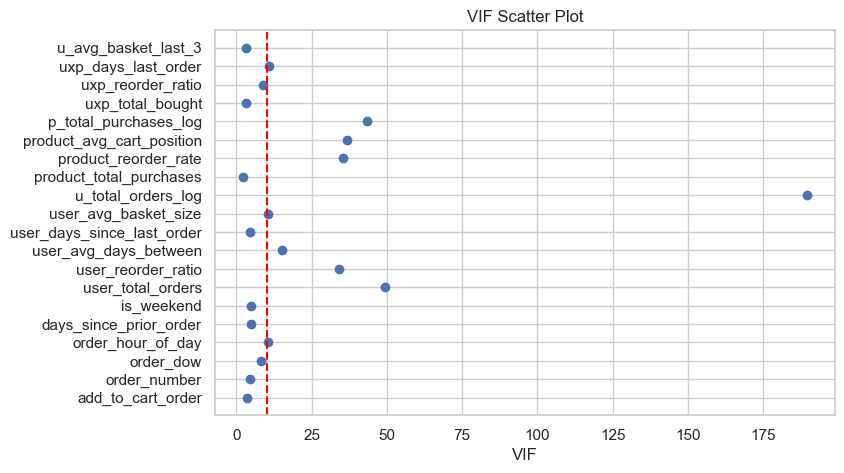

In [217]:
plt.figure(figsize = (8 , 5))
plt.scatter(vif["VIF"] , vif["feature"])
plt.axvline(10 , color = 'red' , linestyle = '--')
plt.xlabel("VIF")
plt.title("VIF Scatter Plot")
plt.show()


In [218]:
#حذفت القيم اللي فيها النسبه عاليه , لانهم بدلو على تكرار وتشابه المعلومات , يعني لو خليتهم كلهم زي كأني مكرر نفس العامود ما فرقت

drop_cols = [
    #"uxp_total_bought" , 
    "user_reorder_ratio" ,   
    "product_avg_cart_position" ,
    "user_avg_days_between" ,

    "u_total_orders_log" ,

    "user_total_orders" ,    
    "p_total_purchases_log" ,
    
    "user_days_since_last_order" , 
    "uxp_days_last_order_"        
]

# التنفيذ
final_df = final_df.drop(columns=drop_cols , errors = "ignore")

# تحديث ليست الأعمدة الرقمية للموديل
num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32", "float32"]).columns.tolist())
num_cols = [c for c in num_cols if c not in id_cols]

6+7: preprocessing and scaling

In [219]:
def best_params_for_TE(DF , high_cols):

    #المشكله اللي صارت انه لما اقسم الداتا , لسا ما شغل البريبروسيسر عليها ف لسا مش كل الفيتشرز تحولو لقيم رقميه
    del DF["product_name"]

    unique_users = DF['user_id'].unique()
    selected_users = np.random.choice(unique_users , size = 3000 , replace=False)
    #رفعت عدد العينات ل 5000 والكود طول لتنه اشتغل ف عشان هيك قللتهم ك حل وسط وهون طلع معي افضل نتيجه بعد عدة تكرارات

    df_check = DF[DF['user_id'].isin(selected_users)].copy()

    df_check[high_cols] = df_check[high_cols].astype(str)

    xc = df_check.drop("reordered", axis=1)
    yc = df_check['reordered']

    xc_train , xc_test , yc_train , yc_test = train_test_split(xc , yc , test_size = 0.2 , random_state = 42)

    pipeline = make_pipeline(
        ce.TargetEncoder(cols=high_cols) ,
        RandomForestClassifier(
            n_estimators = 100 ,  
            max_depth = 10 ,      
            random_state = 42 ,
            n_jobs = -1
        )
    )

    param_grid = {
        'targetencoder__smoothing': [1, 10, 50] ,
        'targetencoder__min_samples_leaf': [1, 20]
    }

    grid_search = GridSearchCV(
        estimator = pipeline ,
        param_grid = param_grid ,
        cv = 3 ,
        scoring = 'roc_auc' ,
        verbose = 1
    )

    print("\n")
    grid_search.fit(xc_train, yc_train)

    print(f"Best ROC_AUC: {grid_search.best_score_:.4f}")
    print("Best Parameters:")
    print(grid_search.best_params_)

    #تجربه فاشله لتحديد افضل المعاملات
    #السبب انه عدد العينات كبير نسبيا ومدامني بجرب كل رقم بلوب لحال ف رح يوخذ مني وقت كبيييييير جدااااا
    '''
    smoothing_op = [1, 2, 10, 20, 50, 100]
    leaf_op = [1, 5, 10, 20, 50]
    Kfold_op = [3, 5, 10]

    results = []

    print("-" * 50)

    for k in Kfold_op:
        current_kf = KFold(n_splits=k, shuffle=True, random_state=42)

        for sm in smoothing_op:
            for leaf in leaf_op:

                encoder = ce.TargetEncoder(
                    cols=high_cols,
                    min_samples_leaf=leaf,
                    smoothing=sm
                )

                model = LogisticRegression(solver='liblinear')

                pipeline = make_pipeline(encoder, model)

                try:
                    scores = cross_val_score(pipeline, xc, yc, cv=current_kf, scoring="roc_auc")
                    mean_auc = scores.mean()
                    std_auc = scores.std()

                    results.append({
                        'n_splits': k,
                        'smoothing': sm,
                        'min_samples_leaf': leaf,
                        'auc_mean': mean_auc,
                        'auc_std': std_auc
                    })

                    print(f"K={k}, Smooth={sm}, Leaf={leaf} -> AUC: {mean_auc:.4f}")

                except Exception as e:
                    print(f"Error at K={k}, Smooth={sm}, Leaf={leaf}: {e}")

    results_df = pd.DataFrame(results)

    sorted_results = results_df.sort_values(by='auc_mean', ascending=False)

    print("\n")
    print("TOP 3 PARAMETER COMBINATIONS:")
    print(sorted_results.head(3))
    print()

    if not sorted_results.empty:
        best_params = sorted_results.iloc[0]
        print(f"\nthe best:\nSmoothing: {best_params['smoothing']}\nMin Samples Leaf: {best_params['min_samples_leaf']}\nK-Fold Splits: {int(best_params['n_splits'])}")
    '''

In [220]:
def which_scaler(num_cols, DF):

    SAMPLE_SIZE = 500000

    df_sampled = DF.sample(n = SAMPLE_SIZE , random_state = 42).copy()


    fig , axes = plt.subplots(len(num_cols) , 1 , figsize = (8 , 4 * len(num_cols)))
    plt.subplots_adjust(hspace = 0.4)
    
    if len(num_cols) == 1:
        axes = [axes]

    for i , col in enumerate(num_cols):
        
        sns.histplot(
            df_sampled[col] ,
            kde = True ,
            ax = axes[i] , 
            color = 'skyblue' ,
            edgecolor = 'black' ,
            line_kws = {'linewidth': 3}
        )
        axes[i].set_title(f'Distribution of {col}' , fontsize = 12)
        axes[i].set_xlabel(col , fontsize = 10)
        axes[i].grid(axis = 'y' , linestyle='--' , alpha = 0.7)

    plt.savefig('numerical_features_distribution_analysis.png' , bbox_inches = 'tight')
    plt.show()

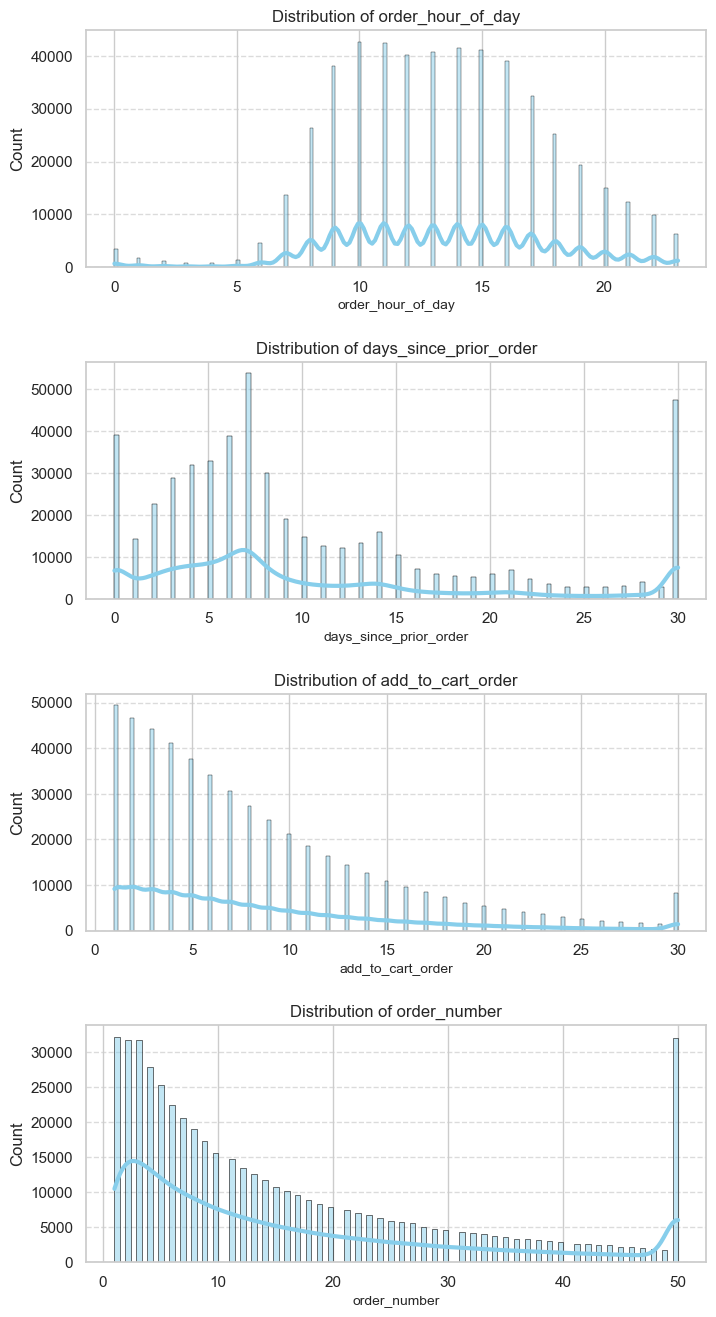

In [221]:

num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
'''low_cols = ["department_id", "order_dow"]
high_cols = ["user_id", "product_id", "aisle_id"]
target_col = "reordered"
Frequency_col = "product_name"
'''


#الرسم ببينلك انه التوزيع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام
#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي

which_scaler(num_cols , final_df)


In [222]:
print("Numeric Columns:" , len(num_cols))
print(num_cols)

#بعد اكثر من تجربه افضل ناتج طلعلي كن زي اللي حطيتهم بالبريبروسيس تحت 
#best_params_for_TE(final_df , high_cols)

Numeric Columns: 4
['order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order', 'order_number']


8: Imbalanced data handling (classification)

In [223]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 22 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   order_id                 int32   
 1   product_id               object  
 2   add_to_cart_order        int32   
 3   reordered                int32   
 4   user_id                  object  
 5   eval_set                 category
 6   order_number             int32   
 7   order_dow                int32   
 8   order_hour_of_day        int32   
 9   days_since_prior_order   float32 
 10  product_name             category
 11  aisle_id                 object  
 12  department_id            int32   
 13  time_of_day              category
 14  is_weekend               int32   
 15  user_avg_basket_size     float32 
 16  product_total_purchases  float32 
 17  product_reorder_rate     float32 
 18  uxp_total_bought         float32 
 19  uxp_reorder_ratio        float32 
 20  uxp_days_last_order   

In [224]:
col_name = ["user_id" , "aisle_id" , "product_id"]

final_df[col_name] = reduce_memory(final_df[col_name])
final_df.info()

C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("category")        #elif col_type == "object":
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("category")        #elif col_type == "object":
C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\458328804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 22 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   order_id                 int32   
 1   product_id               category
 2   add_to_cart_order        int32   
 3   reordered                int32   
 4   user_id                  category
 5   eval_set                 category
 6   order_number             int32   
 7   order_dow                int32   
 8   order_hour_of_day        int32   
 9   days_since_prior_order   float32 
 10  product_name             category
 11  aisle_id                 category
 12  department_id            int32   
 13  time_of_day              category
 14  is_weekend               int32   
 15  user_avg_basket_size     float32 
 16  product_total_purchases  float32 
 17  product_reorder_rate     float32 
 18  uxp_total_bought         float32 
 19  uxp_reorder_ratio        float32 
 20  uxp_days_last_order   

اللي قاعد بصير هسا اني نقلت الانكوديرز لبعد مرحلة الهندسه , ليش ؟
لانه بكل بساطه احترت كيف فعليا المفروض نسوي انكودينق للاعمده الجديده اللي عملناهم بعد الهندسه وكان هاض الحل الوحيد المنطقي ++ ما بزبط اسوي
VIF وانا عامل انكودينق

In [238]:
"""#الموضوع هاض عباره عن وجود عدم توازين في تصنيف البيانات , مثلا الكلاس الاول نسبته اعلى من الثاني , ف هيك الموديل بصير يعتمد عالاول ويهمل الثاني
#ف هيك بصير الموديل فاشل باكتشاف الانماط الجديد

#تجهيز بيانات التصنيف#

#جبت عينات من الداتا لانه اللابتوب شلف عندي لما اشتغلت عالداتا كامله , حاولت اكبر نسبة العينات قد ما بقدر
SAMPLE_SIZE = 1000000
final_sample = final_df.sample(n = SAMPLE_SIZE , random_state = 42)

x_c = final_sample.drop("reordered", axis=1)
y_c = final_sample["reordered"]

xc_train , xc_test , yc_train , yc_test = train_test_split(x_c , y_c , test_size = 0.3 , stratify = y_c , random_state = 42)

#طلعلي هيك SettingWithCopyWarning
xc_train = xc_train.copy()
xc_test  = xc_test.copy()

#هالحركه سويتها بعد ما متت وانا بحلل الكود بعد ما طلعلي التنبيه هاض
#Warning: No categorical columns found. Calling 'transform' will only return input data.
#لما راجعت الانكوديرز تذكرت انه التارقيت ما بشتغل غير مع نصوص والاعمده اللي انا معطيه اياهم رقميات

train_cls = preprocessor.fit_transform(xc_train , yc_train)
test_cls = preprocessor.transform(xc_test)

''''''''''''''''''''''''''''''''''''''''''''''''
#طيب هون بالتايم اوير سبلتنق المفروض نقسم الداتا حسب التوقيت طيب ليش ؟
#الداتا الجديده بقصد فيها الي صارت اخر شي او الطلبات الجديده او يعني الي اخر اشي عمله الزبون
#اولا عشان التقسيم العشوائي بالداتا تبعتنا بعمللنا مشكله شو المشكله هي انو المودل لما يجي يعمل فيت للداتا رح يعمل فيت ويتعلم على داتا جدي
#بعد مايعمل فيت على داتا ممكن تكون جديده ممكن يكون التيست عنا داتا قديمه فهيك المودل رح يكون متعلم من داتا الجديده وهيك بغش حالو
#وهيك بغش حالو  وبجيب اكيورسي عاليه كذابه تمام فا لازم نحل هالمشكله
#طيب لازم نعمل سامبل سايز لانو الامور هيك حتصير كثير كبيره بدونو ومع السموت هاض الداتا بتتضاعف ومابتحمل الرام
#ولازن مانتسخدم السامبلز سايز عادي عشان مانخرب توزيع الداتا افضل يعني
#لو استحدمت سامبلنق عادي رح نفقد كثير داتا يعني مثلا ممكن ليوز معين نفقد الاوردر تاعو رقم 3 او اورد رقم 5
#بينما باليوزر سامبلنق انا باخذ كل الداتا لاشخاص اقل بس
#  User Sampling
unique_users = final_df['user_id'].unique()

# هون السايز خليتو انتجر لانو مثيود الرانودوم تشويس لازمها عدد صحيح مش عشري
new_size = int(len(unique_users) * 0.05)

#  اخترت اليوزرز بشكل عشوائي بدون تكرار
my_users = np.random.choice(unique_users, size=new_size , replace=False)

#  فلترت الداتا خليت بس الأسطر اللي بتخص اليوزرز اللي اخترتهم
final_sample = final_df[final_df['user_id'].isin(my_users)].copy()
# هسا لازم نتاكد انو الداتا مرتبه

final_sample = final_sample.sort_values(by=["user_id","order_number"])

# هسا بعد مارتبنا مطلوب منا نعمل نقسم الداتا طيب شو في طريقه نقسمها في اكثر من طريقه لكن كلهم معقدين فا هاي ابسط اشي لحالتنا
#الي هي انو نعمل كولوم جديده نحط فيه الداتا الجديده تمام وبنقسم على ااساسها
#هون الهدف نعمل كولوم جديد فيه قيم صح وخطا الان القيم الصح او الترو بنحطها للتيست وقيم الفولس بنحطها للترين تمام ها
#الان كيف نعمل هاي القصه من خلال انو بنمرر كولم الاوردر نمبر تمام وبنقارن كل اوردر لكل يوزر مع الماكس او الطلب الاخير لهاض اليوز
#فلو كان اليوزر الطلب الي بنقارنه هو نفسه الطلب الاخير اله حيرجع ترو تمام
#هون جربت استخدم بدون ترانسفورم لاني ماكنت اعرفها طلع عندي ايرور والايرور لانو لو خليت الميثود بدونها رح ترجعلي داتا مضغوطه لانو بجيب الزبده لكل
#لانو بجيب الزبده لكل كولوم فالحل ترانسفورم عشان نطبق الماكس عكل نقطه داتا عندي تم ؟ تم

final_sample["last__orders"]= final_sample["order_number"] == final_sample.groupby("user_id")["order_number"].transform("max")
#هون قسمنا زي ما مطلوب منا
train_df = final_sample[final_sample['last__orders'] == False]
test_df = final_sample[final_sample['last__orders'] == True]
#===

# هون بدنا نقسم الداتا تاعت التريت بدنا نعطي الاكس الكولمز المهمه بس ونشيل كولوم التارقيت منها
not_for_X_columns = ['reordered', 'eval_set', 'last__orders',  'order_id',]
X_train = train_df.drop(columns=not_for_X_columns, errors='ignore')
y_train = train_df['reordered']

#نفس الشي للتيست
X_test = test_df.drop(columns=not_for_X_columns, errors='ignore')
y_test = test_df['reordered']

# Fit على التدريب فقط
train_cls = preprocessor.fit_transform(X_train , y_train)
test_cls = preprocessor.transform(X_test)
"""

target_users_count = 3000

np.random.seed(42)
unique_users = final_df['user_id'].unique()

my_users = np.random.choice(unique_users , size=target_users_count , replace=False)

final_sample = final_df[final_df['user_id'].isin(my_users)].copy()

final_sample = final_sample.sort_values(by=["user_id", "order_number"])
final_sample["last__orders"] = final_sample["order_number"] == final_sample.groupby("user_id")["order_number"].transform("max")

train_df = final_sample[final_sample['last__orders'] == False]
test_df = final_sample[final_sample['last__orders'] == True]

not_for_X_columns = ['reordered' , 'eval_set' , 'last__orders' ,  'order_id' , 'add_to_cart_order' , "uxp_total_bought" , "is_weekend" , "days_since_prior_order"] #'order_number'

xc_train = train_df.drop(columns=not_for_X_columns , errors='ignore')
yc_train = train_df['reordered']

xc_test = test_df.drop(columns = not_for_X_columns , errors = 'ignore')
yc_test = test_df['reordered']

real_num_cols = [c for c in num_cols if c not in not_for_X_columns]
real_low_cols = [c for c in low_cols if c not in not_for_X_columns]
real_high_cols = [c for c in high_cols if c not in not_for_X_columns]

#مدامني قسمت الداتا حسب الزمن فهيك عالاغلب مش رح احتاجه
KF = KFold(n_splits = 3 , shuffle = True , random_state = 42)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoding" , OneHotEncoder(handle_unknown = "ignore" , sparse_output = True , drop = "first") , real_low_cols) ,

        # Target Encoding يُستخدم مع الأعمدة الفئوية ذات عدد القيم الكبير.
        # يتم تحويل كل فئة إلى متوسط قيمة المتغير الهدف المرتبط بها.
        # لتجنب تسريب الهدف (Target Leakage)، يتم تطبيق الترميز داخل
        # الـ Cross-Validation بحيث يُحسب الترميز من بيانات التدريب فقط.
        # معاملات min_samples_leaf و smoothing تقلل تأثير الفئات النادرة
        # عبر تقريبها من المتوسط العام، مما يحد من الـ overfitting.
        ("target_encoding" , ce.TargetEncoder(min_samples_leaf = 20 , smoothing = 50) , real_high_cols) ,
        ("Frequency" , ce.CountEncoder(normalize = True) , Frequency_col) ,
        ("scaling" , StandardScaler() , real_num_cols)
                 ]
)
# معامل الفريكوانسي ترو ليش؟ , لانه اذا حطيتو فولز اللي رح يصير انه رح يوخذ عدد التكرارات زي ما هو في هيك بصير عندي تباين كبير ورح يصير بحاجه لسكيلينق
#اما هيك اللي رح يعملو انه رح يحولهم لنسبة بين ال 0 وال 1



train_cls = preprocessor.fit_transform(xc_train , yc_train)
test_cls = preprocessor.transform(xc_test)

C:\Users\Ameen\AppData\Local\Temp\ipykernel_5332\1673406476.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_sample["last__orders"] = final_sample["order_number"] == final_sample.groupby("user_id")["order_number"].transform("max")


In [239]:
print(train_df.columns)


Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'time_of_day', 'is_weekend', 'user_avg_basket_size',
       'product_total_purchases', 'product_reorder_rate', 'uxp_total_bought',
       'uxp_reorder_ratio', 'uxp_days_last_order', 'u_avg_basket_last_3',
       'last__orders'],
      dtype='object')


In [240]:
#اصريت اتأكد انه الترانسفورم تطبق
print(train_cls.shape)
print(xc_train.shape)
print()
preprocessor.get_feature_names_out()

(403124, 35)
(403124, 15)



array(['encoding__department_id_2', 'encoding__department_id_3',
       'encoding__department_id_4', 'encoding__department_id_5',
       'encoding__department_id_6', 'encoding__department_id_7',
       'encoding__department_id_8', 'encoding__department_id_9',
       'encoding__department_id_10', 'encoding__department_id_11',
       'encoding__department_id_12', 'encoding__department_id_13',
       'encoding__department_id_14', 'encoding__department_id_15',
       'encoding__department_id_16', 'encoding__department_id_17',
       'encoding__department_id_18', 'encoding__department_id_19',
       'encoding__department_id_20', 'encoding__department_id_21',
       'encoding__order_dow_1', 'encoding__order_dow_2',
       'encoding__order_dow_3', 'encoding__order_dow_4',
       'encoding__order_dow_5', 'encoding__order_dow_6',
       'encoding__time_of_day_Evening', 'encoding__time_of_day_Midnight',
       'encoding__time_of_day_Morning', 'target_encoding__user_id',
       'target_encoding__

🔍 Starting Feature Forensic Analysis...

📋 List of All Features used in Training:
----------------------------------------
1. product_id
2. user_id
3. order_number
4. order_dow
5. order_hour_of_day
6. product_name
7. aisle_id
8. department_id
9. time_of_day
10. user_avg_basket_size
11. product_total_purchases
12. product_reorder_rate
13. uxp_reorder_ratio
14. uxp_days_last_order
15. u_avg_basket_last_3

📊 Correlation with TARGET (Suspicion Level):
----------------------------------------
uxp_reorder_ratio          0.725998
order_number               0.338362
product_reorder_rate       0.303066
uxp_days_last_order        0.278208
product_total_purchases    0.137922
u_avg_basket_last_3        0.104486
user_avg_basket_size       0.088433
order_dow                 -0.003474
order_hour_of_day         -0.020141
department_id             -0.037024
Name: TARGET, dtype: float64

📉 Lowest 5 columns (Negative Correlation):
u_avg_basket_last_3     0.104486
user_avg_basket_size    0.088433
order_do

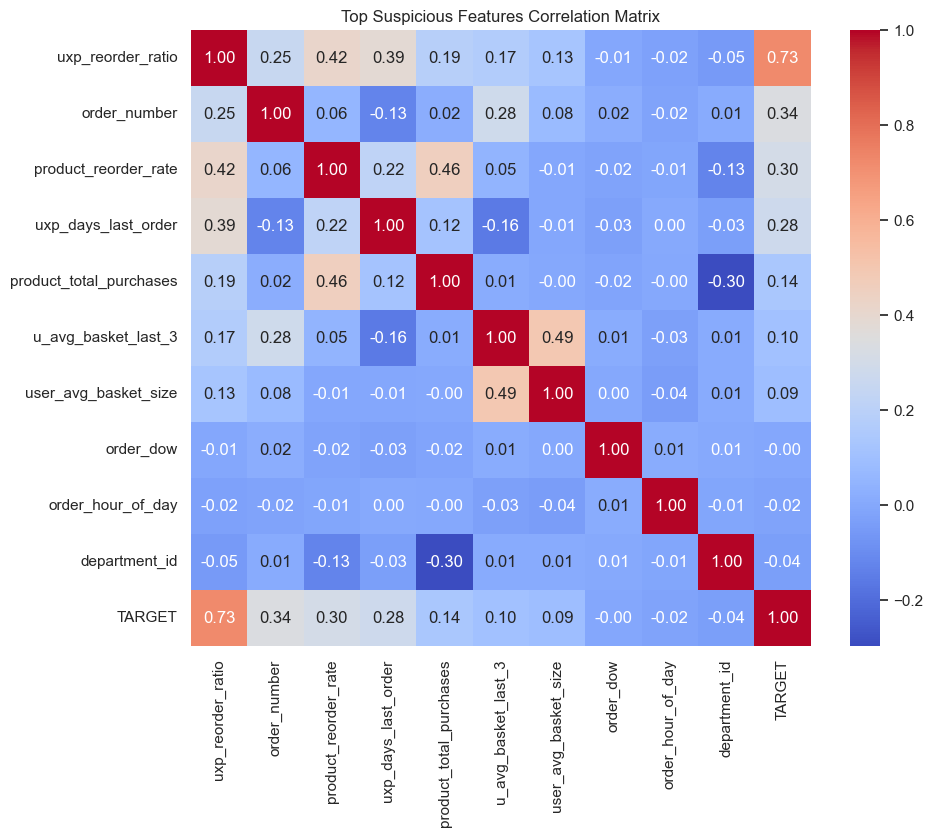

In [241]:
print("🔍 Starting Feature Forensic Analysis...")


inspection_df = xc_train.copy()
inspection_df['TARGET'] = yc_train 

print("\n📋 List of All Features used in Training:")
print("-" * 40)
cols = xc_train.columns.tolist()
for i, col in enumerate(cols):
    print(f"{i+1}. {col}")

print("\n📊 Correlation with TARGET (Suspicion Level):")
print("-" * 40)

numeric_corr = inspection_df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

numeric_corr = numeric_corr.drop('TARGET', errors='ignore')

print(numeric_corr.head(10))

print("\n📉 Lowest 5 columns (Negative Correlation):")
print(numeric_corr.tail(5))


top_features = numeric_corr.head(10).index.tolist()
if len(top_features) > 0:
    plt.figure(figsize=(10, 8))
    top_features.append('TARGET')
    sns.heatmap(inspection_df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Top Suspicious Features Correlation Matrix")
    plt.show()
else:
    print("No numeric features found to plot.")

reordered
1    0.565632
0    0.434368
Name: proportion, dtype: float64


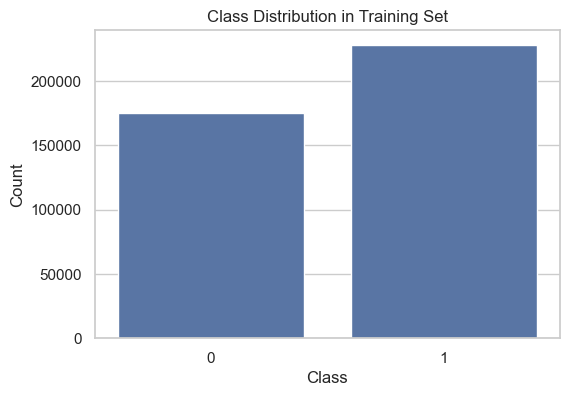

In [242]:
print(yc_train.value_counts(normalize=True))

plt.figure(figsize=(6 , 4))
sns.countplot(x=yc_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#هيك بين عندي انه في تفاوت بنسب الكلاسين اللي عندي , الفرق ما بأثر كثير بس لازم اعمل موازنه لانه الدكتور طلب
#تصحيح للكومنت اللي فوق هاض , التفاوت هاض كثير بأثر وممكن يعمل مشاكل , خصوصا بموديلات كسوله مثل ال KNN و ال Decision Trees
#ف لازم اعمل موازنه بين الكلاسين عشان ما ندمر الدنيا

In [243]:
print("Train target distribution:")
print(yc_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(yc_test.value_counts(normalize=True))

Train target distribution:
reordered
1    0.565632
0    0.434368
Name: proportion, dtype: float64

Test target distribution:
reordered
1    0.690072
0    0.309928
Name: proportion, dtype: float64


In [244]:
#قللت عدد العينات لانه فجأه الكود بطل يشتغل ابصر شو صار
target_users = 1200
unique_users = xc_train['user_id'].unique() 

sample_size = min(target_users , len(unique_users))
selected_users = np.random.choice(unique_users , size = sample_size , replace = False)


user_mask = xc_train['user_id'].isin(selected_users)


X_sample = train_cls[user_mask.values] if hasattr(user_mask , 'values') else train_cls[user_mask]
y_sample = yc_train[user_mask]

smote = SMOTE(random_state=42)
#ما بصير اشفغل السموت على بيانات الاختبار , لانه هيك انا بخسر عنصر الواقعيه , وبخسر ميزة اختبار الموديل عالواقع وعلى سلوك البشر
smote_xtrain , smote_ytrain = smote.fit_resample(X_sample , y_sample) #بتعمل KNN
#اللي بصير هون انه السموت رح تزيد قيم الكلاس القليل بقيم ثناعيه او وهميه عشان التوازن
#بس المشكله انه القيم اللي بتعملها وهميه وما الها اي مستخدم حقيقي , ف استخدامها  مش احسن اشي
print(smote_ytrain.value_counts())

reordered
0    91343
1    91343
Name: count, dtype: int64


In [245]:
rus = RandomUnderSampler(random_state = 42)
under_xtrain , under_ytrain = rus.fit_resample(train_cls , yc_train)
#هاي بتحذف من الكلاس الكبير بطريقه يصير قريب للكلاس الاقل , فيها مشكله انه ممكن تخسر بيانات مهمه من وراها واصلا هيك هيك الدقه فيها مش احسن اشي ف ما رح نستخدمها
print(under_ytrain.value_counts())

reordered
0    175104
1    175104
Name: count, dtype: int64


In [ ]:
model_original = RandomForestClassifier(n_estimators = 50 , max_depth = 20 , class_weight = "balanced" , n_jobs = -1)
#class_weight = 'balanced' هاي بتعطي اهميه اكبر للكلاس الاقل , يعني بتعاقب الموديل لما يهمله ف مجازيا بزيد وزنه , تعتبر بديل لكلشي عملناه تحت
#بدونها رح يكون في تحييز للكلاس اللي حجمه اكبر , وليش ؟ لانه الموديل بفهم انه هاض الكلاس لانه اكبر معناها هاض مهم والثاني لا
model_original.fit(train_cls , yc_train)

pred_O = model_original.predict(test_cls)
print(classification_report(yc_test , pred_O))
print(model_original.score(test_cls , yc_test))

print("----------------------------------------------------------------")

model_smote = RandomForestClassifier(n_estimators = 50 , max_depth = 20 , n_jobs = -1)
model_smote.fit(smote_xtrain , smote_ytrain)

pred_S = model_smote.predict(test_cls)
print(classification_report(yc_test , pred_S))
print(model_smote.score(test_cls , yc_test))

#السكور زاد بنسبه خفيفه , استدعاء الفئه اللي كانت اقل تحسن , الدقه قلت بنسبة خفيفه والسبب انه بطل يعتمد على كلاس واحد صار يعتمد على ثنين بالتصنيف ف نسبة الدقه اقل هون


print("----------------------------------------------------------------")

model_under = RandomForestClassifier(n_estimators = 50 , max_depth = 20 , random_state = 42 , n_jobs = -1)
model_under.fit(under_xtrain , under_ytrain)

pred_U = model_under.predict(test_cls)
print(classification_report(yc_test , pred_U))
print(model_under.score(test_cls , yc_test))

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

models_list = [
    (model_original, "Original (Class Weights)"),
    (model_smote, "SMOTE"),
    (model_under, "UnderSampling")
]

for i, (model, title) in enumerate(models_list):
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        test_cls,
        yc_test,
        display_labels=['Not Reordered', 'Reordered'],
        cmap=plt.cm.Blues,
        normalize='true',
        ax=axes[i]
    )
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

#اول مره جربت اشغل هذول عالبيانات قبل التوزيع حسب الزمن , كان تقسيم عشوائي , وطلع معي انع الالفضل سموت , بس بعد التقسيم حسب الزمن رح نعتمد الداتا الاصليه
## رجعت جربت بيانات اكبر وطلع معي السموت اعلى بنسبه بسيييييييطه وعشان هيك مش رح اهتم بالنسبه هاي ورح اعتمد الداتا الاصليه لانها ما بتوخذ وقت عكس السموت

رح نعتمد هذول بالتدريب train_cls , yc_train

وهذول بالاختبار test_cls , yc_test

Task A

In [ ]:
#هون رح اعتمد الاندر , لانه الموديل هون بصنف حسب الاقرب وبحالتي هاي ما بزبط يكون الداتا فيها عدم توازن , وما بقدر استخدم
# class_weight = 'balanced'

'''np.random.seed(42)

small_users = np.random.choice(xc_train['user_id'].unique(), size=3000, replace=False)

xtrain_tune = xc_train[xc_train['user_id'].isin(small_users)].copy()
ytrain_tune = yc_train.loc[xtrain_tune.index].copy()

xtest_tune = xc_test[xc_test['user_id'].isin(small_users)].copy()
ytest_tune = yc_test.loc[xtest_tune.index].copy()'''



np.random.seed(42)
tuning_x = xc_train.copy()
tuning_y = yc_train.copy()

t = TimeSeriesSplit(n_splits = 3)

'''trainK = []
testK = []
k_values = range(1 , 22 , 2)

for n in k_values:
    tempK = KNeighborsClassifier(n_neighbors = n , n_jobs = -1)
    Knn_model = tempK.fit(under_xtrain , under_ytrain)
    trainK.append(tempK.score(x_trainS , y_trainS))
    testK.append(tempK.score(x_testS , y_testS))

print(testK)

plt.plot(k_values , trainK , label = "Traink")
plt.plot(k_values , testK , label = "Testk")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()'''

In [ ]:
def boundary(model_type, X, y, feature1, feature2, sample_size=500):
    """
    model_type: "SVM", "KNN", "LoR", "DT"
    """
    
    # 1. تجهيز الداتا
    if feature1 not in X.columns or feature2 not in X.columns:
        print("❌ الأعمدة غير موجودة")
        return

    X_data = X[[feature1, feature2]].values
    y_data = y.values

    # 2. Sampling
    np.random.seed(42)
    if len(X_data) > sample_size:
        idx = np.random.choice(np.arange(len(X_data)), size=sample_size, replace=False)
        X_vis = X_data[idx]
        y_vis = y_data[idx]
    else:
        X_vis = X_data
        y_vis = y_data

    # 3. Scaling
    scaler = StandardScaler()
    X_vis = scaler.fit_transform(X_vis)

    # 4. اختيار الموديل حسب طلبك
    if model_type == "SVM":
        clf = SVC(kernel="rbf", C=1.0, gamma='auto')
        title = "SVM (RBF Kernel)"
    elif model_type == "KNN":
        clf = KNeighborsClassifier(n_neighbors=5)
        title = "KNN (k=5)"
    elif model_type == "LoR":
        clf = LogisticRegression()
        title = "Logistic Regression"
    elif model_type == "DT":
        clf = DecisionTreeClassifier(max_depth=5, random_state=42)
        title = "Decision Tree"
    else:
        print("❌ اسم الموديل غلط! اختار: SVM, KNN, LoR, DT")
        return

    # 5. التدريب والرسم
    print(f"🚀 جاري رسم {title} ...")
    clf.fit(X_vis, y_vis)

    # Meshgrid
    x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
    y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # التوقع والرسم
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=plt.cm.coolwarm, s=40, edgecolors="k", alpha=0.8)
    
    plt.title(f"Decision Boundary: {title}", fontsize=15)
    plt.xlabel(feature1 + " (Scaled)")
    plt.ylabel(feature2 + " (Scaled)")
    plt.show()

In [ ]:
def evaluate_classification_model(model, X_test, y_test, model_name="Model"):
    # التوقعات
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]

    # 2  Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ap = average_precision_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    #
    print(f"\n {model_name} Final Report:")

    print(f"\nAccuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC-ROC: {roc_auc:.4f} | Avg Precision: {ap:.4f}")
    print("=" *50)
    fig, axes = plt.subplots(5, 1, figsize=(10, 35))

    # 1. Confusion Matrix Raw Counts
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 16})
    axes[0].set_title("1. Confusion Matrix Raw Counts", fontsize=16, pad=15)
    axes[0].set_xlabel("Predicted", fontsize=12)
    axes[0].set_ylabel("Actual", fontsize=12)

    # 2 Confusion Matrix Normalized
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1], annot_kws={"size": 16})
    axes[1].set_title("2. Confusion Matrix Normalized ", fontsize=16, pad=15)
    axes[1].set_xlabel("Predicted", fontsize=12)
    axes[1].set_ylabel("Actual", fontsize=12)

    # 3. ROC Curve
    axes[2].plot(fpr, tpr, color='darkorange', lw=3, label=f'AUC = {roc_auc:.2f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_title("3. ROC Curve", fontsize=16, pad=15)
    axes[2].set_xlabel("False Positive Rate", fontsize=12)
    axes[2].set_ylabel("True Positive Rate", fontsize=12)
    axes[2].legend(loc="lower right", fontsize=12)

    # 4 Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    axes[3].plot(recall, precision, color='green', lw=3, label=f'AP = {ap:.2f}')
    axes[3].set_title("4. Precision-Recall Curve", fontsize=16, pad=15)
    axes[3].set_xlabel("Recall", fontsize=12)
    axes[3].set_ylabel("Precision", fontsize=12)
    axes[3].legend(loc="lower left", fontsize=12)

    # 5 Calibration Curve Reliability Diagram
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    axes[4].plot(prob_pred, prob_true, marker='o', lw=2, label=f'{model_name}')
    axes[4].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    axes[4].set_title("5. Calibration Curve Reliability", fontsize=16, pad=15)
    axes[4].set_xlabel("Predicted Probability", fontsize=12)
    axes[4].set_ylabel("Actual Probability", fontsize=12)
    axes[4].legend(fontsize=12)

    plt.subplots_adjust(hspace=0.4)
    plt.show()

    return  {
        "Model": model_name ,
        "F1": f1 ,
        "AUC": roc_auc ,
        "Accuracy": acc ,
        "Precision": prec ,
        "Recall": rec ,
        "Avg Precision": ap
           }

In [ ]:
# هاش عشان بالنهايه نضيفهم كلهم مع بعض
all_models_results = []

In [ ]:
#هاض ببينلك كيف بتتغير الدقه مع زيادة \ تغيير حجم الداتا 

def learning_curves_cls(model , x_train , y_train , cv):

    train_sizes=np.linspace(0.1, 1.0, 5)

    train_sizes , train_scores , test_scores = learning_curve(
        model , 
        x_train , y_train ,
        cv = cv , n_jobs = -1 
    )

    train_mean = np.mean(train_scores , axis = 1)
    train_std  = np.std(train_scores , axis = 1)
    test_mean  = np.mean(test_scores , axis = 1)
    test_std   = np.std(test_scores , axis = 1)

    plt.figure()
    plt.title("Learning Curve (Full Data)")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    #  المعادله هاي عشان ارسم التباين
    plt.fill_between(train_sizes , train_mean - train_std , train_mean + train_std , alpha = 0.1 , color = "r")
    plt.fill_between(train_sizes , test_mean - test_std , test_mean + test_std , alpha = 0.1 , color = "g")

    plt.plot(train_sizes , train_mean , 'o-' , color = "r" , label = "Training score")
    plt.plot(train_sizes , test_mean , 'o-' , color = "g" , label = "Cross-validation score")

    plt.legend(loc = "best")
    plt.show()

In [ ]:
def val_curves(model , x_train , y_train , param_name , cv , param_range):

    train_scores, test_scores = validation_curve(
        model , 
        x_train , 
        y_train , 
        param_name = param_name , 
        param_range = param_range ,
        cv = cv , 
        scoring = "accuracy" ,
        n_jobs = -1
    )

    train_mean = np.mean(train_scores , axis=1)
    train_std = np.std(train_scores , axis=1)
    test_mean = np.mean(test_scores , axis=1)
    test_std = np.std(test_scores , axis=1)

    plt.figure(figsize = (10, 6))
    plt.title("Validation Curve")
    plt.xlabel("Param (Complexity)")
    plt.ylabel("score (Higher is Better)")

    plt.plot(param_range, train_mean , label = "Training Score" , color = "darkorange", lw = 2 , marker = 'o')
    plt.fill_between(param_range, train_mean - train_std , train_mean + train_std , alpha = 0.1 , color = "darkorange")

    # رسم منطقة التيست
    plt.plot(param_range , test_mean , label = "Validation Score" , color = "navy" , lw = 2, marker = 'o')
    plt.fill_between(param_range , test_mean - test_std , test_mean + test_std , alpha = 0.1 , color = "navy")

    plt.legend(loc = "best")
    plt.grid()
    plt.show()

1- KNN

In [ ]:
'''FAST_TUNING_USERS = 1000

np.random.seed(42)
# بنختار عينة جديدة صغيرة من العينة الأصلية الكبيرة
KNNsmall_users = np.random.choice(xtrain_tune['user_id'].unique(), size=800, replace=False)

# تصفية الداتا
knn_x_small = xtrain_tune[xtrain_tune['user_id'].isin(small_users)].copy()
knn_y_small = ytrain_tune[xtrain_tune['user_id'].isin(small_users)]

KNN_pipline = make_pipeline(
    preprocessor ,
    KNeighborsClassifier()
)


t = TimeSeriesSplit(n_splits = 3)

param_grid = {
    "kneighborsclassifier__n_neighbors": [7 , 10 , 20 , 25 , 30] ,
    "kneighborsclassifier__weights" : ['distance' , 'uniform']
}

KNN_grid_search = GridSearchCV(
    estimator = KNN_pipline ,
    param_grid = param_grid ,
    cv = t ,
    scoring = 'f1' ,
    n_jobs = -1 ,
    verbose=3
)

print("Done.....")

KNN_grid_search.fit(knn_x_small , knn_y_small)

print("Best CV score:" , KNN_grid_search.best_score_)
print("Best params:" , KNN_grid_search.best_params_)'''

KNNsmall_users = np.random.choice(tuning_x['user_id'].unique() , size = 2000 , replace = False)

knn_x_small = tuning_x[tuning_x['user_id'].isin(KNNsmall_users)].copy()
knn_y_small = tuning_y[tuning_x['user_id'].isin(KNNsmall_users)]

KNN_pipline = make_pipeline(
    preprocessor ,
    KNeighborsClassifier(n_jobs = -1)
)

KNNparam_grid = {
    "kneighborsclassifier__n_neighbors": [7 , 10 , 20 , 25 , 30] ,
    "kneighborsclassifier__weights" : ['distance' , 'uniform']
}

KNN_grid_search = GridSearchCV(
    estimator = KNN_pipline ,
    param_grid = KNNparam_grid ,
    cv = t ,
    scoring = "f1"
    )

KNN_grid_search.fit(knn_x_small , knn_y_small)

print("\nBest Score:", KNN_grid_search.best_score_)
print("Best Parameters:", KNN_grid_search.best_params_)


In [ ]:
best_w = KNN_grid_search.best_params_['kneighborsclassifier__weights']
best_k = KNN_grid_search.best_params_['kneighborsclassifier__n_neighbors']

finalKNN_pip = make_pipeline(
        KNeighborsClassifier(n_neighbors = best_k , weights = best_w , n_jobs = -1)
)

finalKNN_pip.fit(under_xtrain, under_ytrain)


y_pred_KNN = finalKNN_pip.predict(test_cls)

print(classification_report(yc_test , y_pred_KNN))
print(accuracy_score(yc_test , y_pred_KNN))


learning_curves_cls(finalKNN_pip , under_xtrain, under_ytrain , t)

In [ ]:
results_KNN = evaluate_classification_model(finalKNN_pip , test_cls , yc_test , model_name="KNN Classifier")

all_models_results.append(results_KNN)

In [ ]:
col_x = 'user_avg_basket_size'
col_y = 'user_avg_days_between'
boundary("KNN" , xc_train , yc_train , col_x , col_y , sample_size=500)

In [ ]:
#بعد تطبيق تقسيم زمني واقعي ومعالجة عدم التوازن، انخفضت الدقة من قيم مرتفعة غير واقعية إلى ~0.7،
#إلا أن قدرة النموذج على اكتشاف المنتجات المعاد طلبها (Recall) تحسّنت بشكل واضح،
#مما يجعل النموذج أكثر ملاءمة للاستخدام الحقيقي.

2-Logistic Regression

In [ ]:
tuning_users = np.random.choice(tuning_x["user_id"].unique() , size = 2500 , replace = False)

# تجهيز عينة للتونينق
LoR_x_small = tuning_x[tuning_x['user_id'].isin(tuning_users)].copy().sort_values(by=['user_id'])
LoR_y_small = tuning_y.loc[LoR_x_small.index]

LoR_pipline = make_pipeline(
    preprocessor ,
    LogisticRegression(solver = 'liblinear' , class_weight = 'balanced' , random_state = 42)
)

LoRparam_grid = {
    "logisticregression__C": [0.001 , 0.01 , 0.1 , 1 , 10] ,
    "logisticregression__penalty": ['l1' , 'l2']
}

LoR_grid_search = GridSearchCV(
    estimator = LoR_pipline ,
    param_grid = LoRparam_grid ,
    cv = t ,
    scoring = "f1" ,
    n_jobs = -1
)

LoR_grid_search.fit(LoR_x_small , LoR_y_small)

print("\nBest Score:", LoR_grid_search.best_score_)
print("Best Parameters:", LoR_grid_search.best_params_)

"""Best Score: 0.7038598274542919
Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}"""



In [ ]:
best_C = LoR_grid_search.best_params_["logisticregression__C"]
best_P = LoR_grid_search.best_params_["logisticregression__penalty"]

final_LoR_pipeline = make_pipeline(
    preprocessor ,
    LogisticRegression(solver = 'liblinear' , C = 10 , penalty = best_P , class_weight = 'balanced' , random_state = 42 , n_jobs = -1)
)

final_LoR_pipeline.fit(xc_train, yc_train)

y_pred_LoR = final_LoR_pipeline.predict(xc_test)

print(classification_report(yc_test , y_pred_LoR))
print(f"Logistic Accuracy: {accuracy_score(yc_test , y_pred_LoR)}")

learning_curves_cls(final_LoR_pipeline , LoR_x_small , LoR_y_small , t) 

In [ ]:
results_LoR = evaluate_classification_model(final_LoR_pipeline , xc_test , yc_test , model_name = "Logistic Regression")

all_models_results.append(results_LoR)

In [ ]:
boundary("LoR" , xc_train , yc_train , col_x , col_y , sample_size=500)

In [ ]:
#Logistic Accuracy: 0.7295685052244335  الدقه هيك قبل ما اشوف التباين وقب ما اعدل
#Logistic Accuracy: 0.7314973303017143  هيك بعد , مش هالفرق بس كويس


In [ ]:
param_range = [0.001 , 0.01 , 0.1 , 1 , 10]
val_curves(final_LoR_pipeline , xc_train , yc_train , "logisticregression__C" , t , param_range)

In [ ]:
numeric_df = train_df.select_dtypes(include=['number'])
correlations = numeric_df.corrwith(train_df['reordered']).sort_values(ascending=False)

print(correlations.head(10))

In [ ]:
lr_model = final_LoR_pipeline.named_steps['logisticregression'] 
preprocessor = final_LoR_pipeline.named_steps['columntransformer'] 

try:
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
except:
    feature_names = [f"Feature_{i}" for i in range(len(lr_model.coef_[0]))]

if len(feature_names) != len(lr_model.coef_[0]):
    print(f"Mismatch! Names: {len(feature_names)}, Coefs: {len(lr_model.coef_[0])}")
    feature_names = [f"Feat_{i}" for i in range(len(lr_model.coef_[0]))]

coefs = pd.DataFrame({
    'Feature': feature_names ,
    'Coefficient': lr_model.coef_[0]
})

coefs['Abs_Value'] = coefs['Coefficient'].abs()
top_20_coefs = coefs.sort_values(by = 'Abs_Value' , ascending = False).head(20)

plt.figure(figsize = (10 , 8))
colors = ['blue' if x > 0 else 'red' for x in top_20_coefs['Coefficient']]
plt.barh(top_20_coefs['Feature'] , top_20_coefs['Coefficient'] , color = colors)

plt.title("Top 20 Coefficients in Logistic Regression (L2 Regularization)")
plt.xlabel("Coefficient Value (Impact on Log-Odds)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.grid(axis='x' , linestyle = '--' , alpha = 0.7)
plt.show()

In [ ]:
X_train_sample = xc_train.sample(n = 100 , random_state = 42)
X_train_transformed = preprocessor.transform(X_train_sample)

X_test_sample_lin = xc_test.sample(n = 1000 , random_state = 42)
X_test_transformed_lin = preprocessor.transform(X_test_sample_lin)

explainer_linear = shap.LinearExplainer(lr_model , X_train_transformed)
shap_values_linear = explainer_linear.shap_values(X_test_transformed_lin)

plt.figure()
shap.summary_plot(shap_values_linear , X_test_transformed_lin , feature_names = feature_names , show = False)
plt.title("Logistic Regression SHAP Summary" , fontsize = 16)
plt.show()

3- Random Forest

In [ ]:
tuning_users = np.random.choice(tuning_x["user_id"].unique(), size = 800 , replace = False)
RF_x_small = tuning_x[tuning_x['user_id'].isin(tuning_users)].copy().sort_values(by = ['user_id'])
RF_y_small = tuning_y.loc[RF_x_small.index]
 
RF_pipline = make_pipeline(
    preprocessor ,
    RandomForestClassifier(class_weight = "balanced" , random_state = 42 , n_jobs = -1)
)

RFparam_grid = {
    "randomforestclassifier__n_estimators": [100 , 150 , 200] ,
    "randomforestclassifier__max_depth": [10 , 20] ,
    "randomforestclassifier__min_samples_split": [2 , 5 , 10] ,
    "randomforestclassifier__min_samples_leaf": [1 , 2 , 4] ,
    "randomforestclassifier__class_weight": ['balanced' , 'balanced_subsample']
}

RF_grid_search = GridSearchCV(
    estimator = RF_pipline ,
    param_grid = RFparam_grid ,
    cv = t ,
    scoring = "f1" 
)

RF_grid_search.fit(RF_x_small , RF_y_small)

print("\nBest Score:", RF_grid_search.best_score_)
print("Best Parameters:", RF_grid_search.best_params_)

In [ ]:
best_N = RF_grid_search.best_params_["randomforestclassifier__n_estimators"]
best_MD = RF_grid_search.best_params_["randomforestclassifier__max_depth"]
best_MSP = RF_grid_search.best_params_[ "randomforestclassifier__min_samples_split"]
best_MSL = RF_grid_search.best_params_["randomforestclassifier__min_samples_leaf"]
best_W = RF_grid_search.best_params_["randomforestclassifier__class_weight"]

final_RF_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators = 200 , max_depth = 25 ,
                    min_samples_leaf = 20 , min_samples_split = 20 ,
                 class_weight = best_W , n_jobs = -1 , random_state = 42
                        )
)



final_RF_pipeline.fit(xc_train , yc_train)

y_pred_RF = final_RF_pipeline.predict(xc_test)

print(classification_report(yc_test , y_pred_RF))
print(f"Random Forest Accuracy: {accuracy_score(yc_test , y_pred_RF)}")

learning_curves_cls(final_RF_pipeline , xc_train , yc_train , t)

In [ ]:
results_RF = evaluate_classification_model(final_RF_pipeline , xc_test , yc_test , model_name = "Random Forest")

all_models_results.append(results_RF)

In [ ]:
param_range = [1, 3, 5, 8, 10, 15, 20]
val_curves(final_RF_pipeline , xc_train , yc_train , "randomforestclassifier__max_depth" , t , param_range)

4- Gradient boosting classifier

In [ ]:
'''# رح نسخدم هالمره الترين سي ل س عشان معمولها بري بروسس وكلها ارقام لانو لو استخدمنا الداتا العاديه رح نتطر نحذ الكولومز الي مش رقميه وبالتالي نخسر بيانات مهمه
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=1000, replace=False)


# بما أن train_cls يطابق xc_train سطراً بسطر، نستخدم شرط xc_train لقص train_cls
XGB_x_small = train_cls[xc_train['user_id'].isin(tuning_users_ids)].values()
XGB_y_small = yc_train[xc_train['user_id'].isin(tuning_users_ids)].values()

ratio = float(np.sum(XGB_y_small == 0)) / np.sum(XGB_y_small == 1)

print(f"Tuning shape: {XGB_x_small.shape}")
print(f"Calculated Ratio: {ratio:.2f}")
'''

# 1. حدد اليوزرز (كما فعلت)
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=1000, replace=False)

# 2. إنشاء الـ Mask وتحويله لقيم Numpy مباشرة
# الـ .values هي كلمة السر هنا
mask = xc_train['user_id'].isin(tuning_users_ids).values 

# 3. التطبيق
XGB_x_small = train_cls[mask]
XGB_y_small = yc_train[mask] # حتى لو yc_train كانت pandas، ال numpy mask بشتغل عليها عادي

ratio = float(np.sum(XGB_y_small == 0)) / np.sum(XGB_y_small == 1)

print(f"Tuning shape: {XGB_x_small.shape}")
print(f"Calculated Ratio: {ratio:.2f}")

In [ ]:
 # تعريف الموديل مباشرة بدون Pipeline لأن الداتا جاهزة
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=ratio,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

XGBparam_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7]
}


XGB_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = XGBparam_grid,
    cv = 3,
    scoring = "f1",
    n_jobs = -1,

)


XGB_grid_search.fit(XGB_x_small, XGB_y_small)

print("\nBest Score (F1):", XGB_grid_search.best_score_)
print("Best Parameters:", XGB_grid_search.best_params_)
# بعد التعديل ارتفعت السكور من 72 ل 77
# Best Score (F1): 0.7726193292101673
# Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [ ]:
best_LR = XGB_grid_search.best_params_["learning_rate"]
best_NE = XGB_grid_search.best_params_["n_estimators"]
best_MD = XGB_grid_search.best_params_["max_depth"]

# print(f"Learning Rate: {best_LR}, N_Estimators: {best_NE}, Max_Depth: {best_MD}")

In [ ]:
full_ratio = float(np.sum(yc_train == 0)) / np.sum(yc_train == 1)
print(f"Full Data Ratio: {full_ratio:.2f}")


#  #  الموديل النهائي
# final_xgb = XGBClassifier(
#     learning_rate = best_LR,
#     n_estimators = best_NE,
#     max_depth = best_MD,
#     scale_pos_weight = full_ratio,
#     objective = 'binary:logistic',
#     eval_metric = 'logloss',
#     use_label_encoder = False,
#     random_state = 42,
#     n_jobs=-1
# )

# # على كل الداتا
# final_xgb.fit(train_cls, yc_train)


#========================================================
# عشان نعمل خظوه الايرلي سبلتنق لازم نقسم الداتا كمان مره ولازم ننتبه يكون تقسيمنا براعي الزمن الي قسمناه بالبدايه تمام
#لانو الايرلي ستوبنق بحتاج نعمل فاليديشن اكثر من مره حتى يعرف متى يوقف
# بنجيب كل اليوزرز من الداتا الأصلية وبنقسمهم 90% تدريب 10% مراقبة
train_users, val_users = train_test_split(xc_train['user_id'].unique(), test_size=0.10, random_state=42)

# 2. عمل الماسك (Masks) لتحديد أماكن هدول اليوزرز في الداتا
# train_mask: بيحدد أسطر يوزرز التدريب
# val_mask: بيحدد أسطر يوزرز المراقبة
train_mask = xc_train['user_id'].isin(train_users).values
val_mask = xc_train['user_id'].isin(val_users).values

# 3. تطبيق الماسك على الداتا المعالجة الجاهزة (train_cls)
# هيك ضمنا إن X_tr و X_val مفصولين تماماً بناءً على الأشخاص
X_tr = train_cls[train_mask]
y_tr = yc_train[train_mask]

X_val = train_cls[val_mask]
y_val = yc_train[val_mask]

print(f"Train shapes: {X_tr.shape}, Val shapes: {X_val.shape}")


final_xgb = xgb.XGBClassifier(
    learning_rate = best_LR,
    n_estimators = 3000,         # رقم كبير جدا نعطيه راحته
    max_depth = best_MD,
    # scale_pos_weight = full_ratio,
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    early_stopping_rounds = 50,  #وقف اذا ماتحسن بعد 50 راوند
    random_state = 42,
    n_jobs = -1
)

final_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    verbose=False
)

print("-" * 30)
print(f"Training Stopped at iteration: {final_xgb.best_iteration}")
print(f"Best Validation Score: {final_xgb.best_score}")

In [ ]:
y_pred_xgb = final_xgb.predict(test_cls)

print(" XGBoost Report")
print(classification_report(yc_test, y_pred_xgb))

print(f"XGBoost Accuracy: {final_xgb.score(test_cls, yc_test)}")
# هاي النتائج قبل الايرلي ستوبنق
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.50      0.71      0.59     23041
#            1       0.85      0.70      0.77     55245

#     accuracy                           0.70     78286
#    macro avg       0.67      0.71      0.68     78286
# weighted avg       0.75      0.70      0.71     78286

# XGBoost Accuracy: 0.702922617070740

# النتائج هاي بعد الايرلي ستوبنق وفرقت معنا منيح
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.51      0.74      0.60     23041
#            1       0.87      0.70      0.77     55245

#     accuracy                           0.71     78286
#    macro avg       0.69      0.72      0.69     78286
# weighted avg       0.76      0.71      0.72     78286

# XGBoost Accuracy: 0.7107784278159569
#بنلاحظ الاكيروسي زادت تقريبا 1 بالميه
# وال ري كول لكلاس 0 تحسن بشكل منيح من 71 ل 74 يعني المودل صار احسن بالي مابشترو
#======================================


# بعد اضافه تو كولمز مهمين

#  XGBoost Report
#               precision    recall  f1-score   support

#            0       0.75      0.97      0.85     23041
#            1       0.98      0.87      0.92     55245

#     accuracy                           0.90     78286
#    macro avg       0.87      0.92      0.88     78286
# weighted avg       0.92      0.90      0.90     78286


In [ ]:
results_df = pd.DataFrame(XGB_grid_search.cv_results_)

# 2. تنظيف البيانات للرسم
# نختار الأعمدة المهمة ونعيد تسميتها لتكون واضحة في الرسم
plot_df = results_df[[
    'param_max_depth', 
    'param_learning_rate', 
    'mean_test_score'
]].copy()

plot_df.columns = ['Max Depth', 'Learning Rate', 'F1 Score']

# 3. رسم الخطوط باستخدام Plotly
fig = px.line(
    plot_df, 
    x='Max Depth', 
    y='F1 Score', 
    color='Learning Rate', # كل لون يمثل Learning Rate مختلف
    markers=True,          # وضع نقاط عند كل تجربة
    title='Interactive Hyperparameter Tuning: Depth vs. Learning Rate',
    template='plotly_white'
)

# تحسينات المظهر
fig.update_layout(
    xaxis_title='Max Depth (Complexity)',
    yaxis_title='Cross-Validation F1 Score',
    hovermode="x unified" # مقارنة سهلة عند تمرير الماوس
)

fig.show()

# لحفظ الرسم كملف HTML لتسليمه
fig.write_html("xgboost_hyperparameters_tuning.html")

In [ ]:
y_pred_xgb = final_xgb.predict(test_cls)

print(" XGBoost Report")
print(classification_report(yc_test, y_pred_xgb))

print(f"XGBoost Accuracy: {final_xgb.score(test_cls, yc_test)}")
# هاي النتائج قبل الايرلي ستوبنق
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.50      0.71      0.59     23041
#            1       0.85      0.70      0.77     55245

#     accuracy                           0.70     78286
#    macro avg       0.67      0.71      0.68     78286
# weighted avg       0.75      0.70      0.71     78286

# XGBoost Accuracy: 0.702922617070740

# النتائج هاي بعد الايرلي ستوبنق وفرقت معنا منيح
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.51      0.74      0.60     23041
#            1       0.87      0.70      0.77     55245

#     accuracy                           0.71     78286
#    macro avg       0.69      0.72      0.69     78286
# weighted avg       0.76      0.71      0.72     78286

# XGBoost Accuracy: 0.7107784278159569
#بنلاحظ الاكيروسي زادت تقريبا 1 بالميه
# وال ري كول لكلاس 0 تحسن بشكل منيح من 71 ل 74 يعني المودل صار احسن بالي مابشترو
#======================================


# بعد اضافه تو كولمز مهمين

#  XGBoost Report
#               precision    recall  f1-score   support

#            0       0.75      0.97      0.85     23041
#            1       0.98      0.87      0.92     55245

#     accuracy                           0.90     78286
#    macro avg       0.87      0.92      0.88     78286
# weighted avg       0.92      0.90      0.90     78286


In [ ]:
results_xgb = evaluate_classification_model(final_xgb , test_cls , yc_test ,  model_name="XGBoost")

all_models_results.append(results_xgb)

In [ ]:
print("Plotting Feature Importance")

try:

    feature_names = preprocessor.get_feature_names_out()

    clean_names = [name.split('__')[-1] for name in feature_names]

    final_xgb.get_booster().feature_names = clean_names

    fig, ax = plt.subplots(figsize=(12, 10))
    xgb.plot_importance(
        final_xgb,
        ax=ax,
        max_num_features=20,     
        height=0.5,
        importance_type='weight', 
        color='teal',
        title="Top 20 Features Influencing Reorders (XGBoost)"
    )
    plt.show()

except Exception as e:
    print(f"Could not extract feature names automatically (Error: {e}). Plotting by index instead...")

    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(final_xgb, ax=ax, max_num_features=20, height=0.5, color='teal')
    plt.title("Top 20 Features (by Index)")
    plt.show()

In [ ]:
xgboost_model = final_xgb 

X_test_sample = xc_test.sample(n=1000, random_state=42)
y_test_sample = yc_test.loc[X_test_sample.index]

X_test_transformed = preprocessor.transform(X_test_sample)

try:
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
except:
    print("Could not extract feature names automatically.")
    feature_names = [f"Feature_{i}" for i in range(X_test_transformed.shape[1])]


print("Calculating SHAP values")

explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test_transformed)


print("Plotting SHAP Summary Plot")
plt.figure()
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("XGBoost Feature Importance (SHAP)", fontsize=16)
plt.show()


mean_shap = np.abs(shap_values).mean(axis=0)
top_3_indices = np.argsort(mean_shap)[-3:] 

print("Plotting Dependence Plots...")
for idx in top_3_indices:
    shap.dependence_plot(idx, shap_values, X_test_transformed, feature_names=feature_names)


print("Generating Local Explanation (Force Plot)...")

preds = xgboost_model.predict(X_test_transformed)
actual = y_test_sample.values

try:
    target_idx = np.where((preds == 1) & (actual == 1))[0][0]
    
    print(f"Explanation for sample index {target_idx} (Correct Prediction)")
    
    shap.force_plot(
        explainer.expected_value, 
        shap_values[target_idx], 
        X_test_transformed[target_idx], 
        feature_names=feature_names,
        matplotlib=True
    )
except IndexError:
    print("لم يتم العثور على حالة True Positive في العينة المختارة.")



    #الرسمه الاولى بتبينلك قديش تأثير العامود بقرار التنبؤ , يعني اذا كان موجب رايح عاليمين بكون العامود هاض كثير اثر على اعادة الشراء والعكس صحيح
    #كل ما زادت عدد طلبات الزبون بزيد احتمالية اعادة الشراء

    #الرسمه الرابعه , بتوضح انه واحد من العوامل المهمه كثير لاعادة الشراء انه يكون الزبون مشتري نفس المنتج من قبل

    #الرسمه الثالثه بتوضح انه في علاقة عكسية , بمعنى انه مثلا اذا كان الزبون مشتري مبارح ف صعب انه يرجع يشتري كمان مره بعد فتره قصيره نسبيا

    #الصوره الثانيه بتحكي انه مثلا الزبائن الجداد بكون هدفهم يشترو شغلات اساسيه ف عشان هيك بكون في تكرار كثير بالشراء 
    #اما الزبائن القدام بكونو بشترو شغلات جديده عن العاده عشان هيك نسبة اعادة الشراء قليله نسبيا

    #الرسمه الاخيره , مسكنا زبون واحد وشفنا ليش الموديل حكى انه بنسبة 85 بالميه رح يكرر الشراء
    #الاعتماد كان على :

    """
    days_since_prior_order: الزبون صرله فترة مش طالب (القيمة عالية)، فهاد دفش الاحتمالية لفوق.

    uxp_total_bought: الزبون شاري هذا المنتج كثير مرات قبل هيك.

    85 هذا الزبون بيحب هذا المنتج (شراه كثير)، وصرله فترة مش طالبه (خلص من عنده)، لذلك الموديل توقع الشراء بنسبة                  
    """


RF: 0.7339 | LoR: 0.7066 | KNN: 0.7227  قبل

RF: 0.8551 | LoR: 0.7295 | KNN: 0.7630  بعد

5: SVC

In [ ]:
np.random.seed(42)
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=40, replace=False)
#قللنا السايز كثير عشان المودل هاض خصيصا بطيئ بالداتا الكبيره لانو بحتاج يحسب المسافه
#بين كل نقطه وباقي النقاط فلو كانت مثلا 20 الف رح تضربها كمان ب 20 الف بطلع عندك 400 الف عمليه حسابيه
# وهاص الحكي على مره تدريب وحده يعني عشان نعمل قريد سيرش بدنا ندرب قول 3 مرات مثلا رح ال 400 الف بثلاث فا بتفقع الامور عشان هيك لازم السايز قليل
SVC_x_small = xc_train[xc_train['user_id'].isin(tuning_users_ids)].copy().sort_values(by=['user_id'])
SVC_y_small = yc_train.loc[SVC_x_small.index]

print(f"Tuning Sample Size: {SVC_x_small.shape}")

In [ ]:

SVC_pipeline = make_pipeline(  preprocessor, SVC(class_weight='balanced', random_state=42, cache_size=1000)
)
SVC_param_grid = {
    "svc__C": [0.1, 1, 10],

    "svc__kernel": ['linear', 'rbf'],

    # Gamma: (بس للـ rbf) قديش النقطة بتأثر عاللي حولها
    "svc__gamma": ['scale', 'auto']
}

# 3. إعداد الجريد سيرش (الحكم)
SVC_grid_search = GridSearchCV(
    estimator = SVC_pipeline,
    param_grid = SVC_param_grid,
    cv = 3,
    scoring = "f1",
    n_jobs = -1,
    verbose = 1
)




SVC_grid_search.fit(SVC_x_small, SVC_y_small)


print("Best Score (F1):", SVC_grid_search.best_score_)
print("Best Parameters:", SVC_grid_search.best_params_)
# #كان السايز 40 وكان معطيني سكور 69 قلت لو زدت السايز ممكن يزيد لكنه نزل لما زدته هاض بكون بسبب ممكن انو الي زدتهم فيهم نويز اكثر فا عشان هيك
# #بس ال مهم انو المودل اختار نفس البارميترز في الحالين فا هاض دليل انه هذول همه الاوبتمال او المناسبين للداتا تبعتنا

In [ ]:
training_indices = np.random.choice(xc_train.index, size=30000, replace=False)


xc_train_small = xc_train.loc[training_indices].copy()
yc_train_small = yc_train.loc[training_indices].copy()

print(f" Training Data Downsampled : {xc_train_small.shape}")

best_params = SVC_grid_search.best_params_


final_SVC_pipeline = make_pipeline(
    preprocessor,
    SVC(
        C = best_params['svc__C'],
        kernel = best_params['svc__kernel'],
        gamma = best_params['svc__gamma'],
        class_weight = 'balanced',
        random_state = 42,
        cache_size = 2000,
        verbose = True
    )
)

final_SVC_pipeline.fit(xc_train_small, yc_train_small)
# # # optimization finished, #iter = 24601
# # obj = -1859.055235, rho = -0.803259
# # nSV = 21295, nBSV = 14710
# # Total nSV = 21295
# #هاض الحكي الي بهمني منو انو اول اشي المودل احتاج 24 الف اتريشن على داتا زي هيك فهو رقم كويس تمام
# #ثاني اشي بهمني هو ال nSV
# #هو عباره عن عدد النقاط الي اعتبرهم المودل سبورت فيكتور مشين طب ليش طلعو هيك لانو الكومبليكستي واطيه
# #ال c طلعت 0.1
# #عشان هيك المارجن كبير فا اخذ اكثر من سبورت فيكتور لانو المودل سمبل

In [ ]:
y_pred_svc = final_SVC_pipeline.predict(xc_test)
svc_report=classification_report(yc_test, y_pred_svc,output_dict=True)
svc_acc  = svc_report['accuracy']
svc_prec = svc_report['1']['precision']
svc_rec  = svc_report['1']['recall']
svc_f1   = svc_report['1']['f1-score']
print(classification_report(yc_test, y_pred_svc))
# النتائج الي طلعت رائعه
#               precision    recall  f1-score   support

#            0       0.51      0.65      0.57     23041
#            1       0.83      0.74      0.78     55245

#     accuracy                           0.71     78286
#    macro avg       0.67      0.69      0.68     78286
# weighted avg       0.74      0.71      0.72     78286


#=====================================
#بعد اضافه تو كولمز مهمين والتاكد انو مافي داتا لليكيج
#      precision    recall  f1-score   support

#            0       0.78      0.95      0.86     23041
#            1       0.98      0.89      0.93     55245

#     accuracy                           0.91     78286
#    macro avg       0.88      0.92      0.89     78286
# weighted avg       0.92      0.91      0.91     78286


In [ ]:

# تجهيز الـ Scores عشان نستخدمهم في الرسمات الجاية
# الـ decision_function بتعطينا رقم بيعبر عن "بعد النقطة عن الخط الفاصل"
# كل ما كان الرقم أكبر، كان المودل متأكد أكثر إنه Class 1
y_score = final_SVC_pipeline.decision_function(xc_test)
# هاي الدالة بتعطيك المسافة والاتجاه بالضبط عن الخط
#لانو هاي الرسمات بتحتاج لارقام كنتونويس سكور مش ماببزبط معها 0 و 1

In [ ]:
svc_auc = roc_auc_score(yc_test, y_score)
svc_ap = average_precision_score(yc_test, y_score)
svc_final_metrics = {
    "Model": "SVC",
    "Accuracy": svc_acc,
    "Precision": svc_prec,
    "Recall": svc_rec,
    "F1": svc_f1,
    "AUC": svc_auc,
    "Avg Precision": svc_ap
}
all_models_results.append(svc_final_metrics)

In [ ]:
 # Confusion Matrix Raw & Normalized
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Raw
ConfusionMatrixDisplay.from_predictions(
    yc_test, y_pred_svc,
    display_labels=['Not Reordered', 'Reordered'],
    cmap='Blues', ax=axes[0], colorbar=False
)
axes[0].set_title("Confusion Matrix (Raw Counts)")

# Normalized
ConfusionMatrixDisplay.from_predictions(
    yc_test, y_pred_svc,
    display_labels=['Not Reordered', 'Reordered'],
    cmap='Greens', normalize='true', ax=axes[1], colorbar=False
)
axes[1].set_title("Confusion Matrix (Normalized %)")

plt.show()

#المربع الفوق اليسار بعبر عن عدد الناس الي ماشترت والمودل فعلا قال عنهم ما اشترو تمام يعني حسب الرسمتين عنا 65 بالميه جابهم صح
#المربع الي فوق عاليمين هذول الي ما اشترو بس المودل تحمس وقال انهم رح يشترو يعني هون غلط ب 35 بالميه
#اذا الي المربعات الي فوق بتعبر عن الي ما اشترو
#===========================================
 # المربع الي تحت يسار بتعبر عن الناس الي اشترو فعلا بس المودل قال عنهم ما اشترو
# المربع الي تحت يمين بعبر عن الي اشترو وفهلا المودل توقع انهم رح يشترو حققنا True Positive Rate بنسبة 74%
#==================================================================
# الخلاصه
# فوق - يسار True Negative
# فوق - يمين False Positive
# تحت - يسار False Negative
# تحت - يمين True Positive 74% 40900

In [ ]:
 # ROC Curve + AUC
plt.figure(figsize=(8, 6))

# بنستخدم y_score اللي جهزناها فوق
RocCurveDisplay.from_predictions(
    yc_test, y_score,
    name="SVM (RBF)",
    color="orange"
)

#  هون بنرسم خط الحظ الصدفة عشان نقارن فيه
plt.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
plt.title("ROC Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# الخط البرتقالي SVM RBF
#ما إنه مقوس لفوق جهة اليسار فهذا دليل ممتاز
# الخط البرتقالي يببتعد بوضوح عن خط الصدفة Chance Level
# هاض دليل انو المودل تعلم انماط حقيقيه

In [ ]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))

PrecisionRecallDisplay.from_predictions(
    yc_test, y_score,
    name="SVM (RBF)",
    plot_chance_level=True,
    color="purple"
)

plt.title("Precision-Recall Curve ")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.show()
# # بالنسبة لـ Precision-Recall Curve
# هاي الرسمه افضل من الي قبلها لانها بتعطيك كلشي بوضوح
#  هاي هي الرسمه المهمه لللتعامل مع الداتا الي مش متوازنه او الان بلانسد تمام هون بنشوف انو خط الصدفه عالي 0.71 وهاض بيعني فعلا انو الداتا مش متوازنه
# الان المودل المنيح هو الي بقدر يعلي ال AP
# هي بتعبتر عن الافريح اوف بيرسجن يعني معدل الدقه تمام واحنا عليها فوقيه حيث طلع معنا 0.87

In [ ]:
# Decision Boundary
print(" Generating Professional Decision Boundary Plots...")

#  اختيار Continuous Features
col_x = 'user_avg_basket_size'
col_y = 'user_avg_days_between'

# التأكد من وجود الأعمدة (احتياط)
if col_x in xc_train.columns and col_y in xc_train.columns:
    print(f" Found features: {col_x} vs {col_y}")
    X_vis = xc_train[[col_x, col_y]].values
    y_vis = yc_train.values
else:
    print(" Columns not found, falling back to indices.")
    X_vis = xc_train.iloc[:, [13, 12]].values # تقديراً لمواقعهم
    y_vis = yc_train.values

# 2. أخذ عينة (500 نقطة)
np.random.seed(42)
idx = np.random.choice(np.arange(len(X_vis)), size=500, replace=False)
X_vis_small = X_vis[idx]
y_vis_small = y_vis[idx]

# 3. Scaling (مهم جداً جداً هنا)
scaler_vis = StandardScaler()
X_vis_small = scaler_vis.fit_transform(X_vis_small)

# 4. تدريب الموديلات
models = (
    SVC(kernel="linear", C=1.0),
    SVC(kernel="rbf", C=1.0, gamma='auto')
)
models = [clf.fit(X_vis_small, y_vis_small) for clf in models]

# 5. الرسم
titles = (f"Linear SVM\n({col_x} vs {col_y})", f"RBF SVM\n({col_x} vs {col_y})")
fig, sub = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

X0, X1 = X_vis_small[:, 0], X_vis_small[:, 1]
#  عشان المنحنيات تكون ناعمة
xx, yy = np.meshgrid(np.arange(X0.min()-0.5, X0.max()+0.5, 0.02),
                     np.arange(X1.min()-0.5, X1.max()+0.5, 0.02))

for clf, title, ax in zip(models, titles, sub.flatten()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # الرسم بالألوان (Contours)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # رسم النقاط (Scatter)
    ax.scatter(X0, X1, c=y_vis_small, cmap=plt.cm.coolwarm, s=35, edgecolors="k", alpha=0.9)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("User Avg Basket Size (Standardized)")
    ax.set_ylabel("User Avg Days Between (Standardized)")


plt.show()

6: DecisionTree

In [ ]:
np.random.seed(42)
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=2500, replace=False)
# سحب الداتا تاعت هذول  اليوزرز
DT_x_small = xc_train[xc_train['user_id'].isin(tuning_users_ids)].copy().sort_values(by=['user_id'])
DT_y_small = yc_train.loc[DT_x_small.index]
print(f"Sample Size for Tuning: {DT_x_small.shape}")

In [ ]:

DT_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(class_weight='balanced', random_state=42)
)

DT_param_grid = {
    "decisiontreeclassifier__max_depth": [10, 15, 20, None],      # هدول الأعماق
    "decisiontreeclassifier__min_samples_leaf": [20, 50, 100],    #  هدول الأعداد للأوراق
    "decisiontreeclassifier__criterion": ["gini", "entropy"]      # المعادلتين
}

DT_grid_search = GridSearchCV(
    estimator = DT_pipeline,   # البايبلاين اللي عملناه
    param_grid = DT_param_grid,# الاحتمالات اللي فوق
    cv = 3,
    scoring = "f1",
    n_jobs = -1,
    verbose = 1
)

In [ ]:

DT_grid_search.fit(DT_x_small, DT_y_small)

print("\n Tuning Done")
print("Best Score (F1):", DT_grid_search.best_score_)
print("Best Parameters:", DT_grid_search.best_params_)


In [ ]:
best_params = DT_grid_search.best_params_

final_DT_pipeline = make_pipeline(
    preprocessor ,
    DecisionTreeClassifier(
        criterion = best_params['decisiontreeclassifier__criterion'],
        max_depth = best_params['decisiontreeclassifier__max_depth'],
        min_samples_leaf = best_params['decisiontreeclassifier__min_samples_leaf'],
        class_weight = 'balanced',
        random_state = 42
    )
)

final_DT_pipeline.fit(xc_train, yc_train)

In [ ]:
y_pred_dt = final_DT_pipeline.predict(xc_test)

print(classification_report(yc_test, y_pred_dt))

print(f"Decision Tree Accuracy: {final_DT_pipeline.score(xc_test, yc_test)}")
learning_curves_cls(final_DT_pipeline , xc_train , yc_train , t)

In [ ]:
dt_results = evaluate_classification_model(final_DT_pipeline, xc_test , yc_test, model_name="Decision Tree Tuned")

all_models_results.append(dt_results)

In [ ]:
boundary("DT" , xc_train , yc_train , col_x , col_y , sample_size=500)

In [ ]:
param_range = [5, 10, 15, 20, 30]
val_curves(final_DT_pipeline , xc_train , yc_train , "decisiontreeclassifier__max_depth" , t , param_range)

In [ ]:

comparison_df = pd.DataFrame(all_models_results)

comparison_df = comparison_df.round(4)

# ترتيب الجدول حسب  F1-Score من الأعلى للأقل
comparison_df = comparison_df.sort_values(by='F1', ascending=False).reset_index(drop=True)

styled_df = comparison_df.style.highlight_max(axis=0, color='green', subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'Avg Precision'])


styled_df

In [ ]:
final_xgb = XGBClassifier(
    enable_categorical=True,  # <--- هذا هو المفتاح السحري
    n_jobs=-1,
    random_state=42
)

models = {
    "Logistic Regression": final_LoR_pipeline ,
    "Random Forest": final_RF_pipeline ,   
    "KNN Classifier": finalKNN_pip ,
    "Decision Tree": final_DT_pipeline ,
    "XGBoost": final_xgb 
    }



results = []

for name , model in models.items():
    print(f"Testing {name}")
    scores = cross_val_score(model , xc_train , yc_train , cv = 5 , scoring = 'accuracy' , n_jobs = -1)
    
    for score in scores:
        results.append({"Model": name , "Accuracy": score})

df_results = pd.DataFrame(results)

plt.figure(figsize = (12 , 6))
sns.set_style("whitegrid")
sns.boxplot(x = "Model" , y = "Accuracy" , data = df_results , palette = "viridis" , width = 0.5)
sns.stripplot(x = "Model" , y = "Accuracy" , data = df_results , color = 'black' , alpha = 0.5 , jitter = True)
plt.title('Classification Models Benchmark (5-Fold CV)' , fontsize = 15)
plt.ylabel('Accuracy Score' , fontsize = 12)
plt.ylim(0.6 , 1.0)  
plt.show()

#هالرسمه العاطله بتبينلك مقارنه بدقة كل موديل 
#اللوجيستيك الخط تبعه كثير رفيع ف هاض بدل على انه مستقر وشو ما عملت فيه ما رح يزيد
#الراندوم وضعها نار شرار واتوقع لو اني حطيت ال سي في 10 كان رح يعطيني احتمالية اكيوريسي اعلى بس جهازي رح يفقع طبعا
#ال كنن زباله ورح يضل طول عمره زباله

Task B

In [ ]:
#اول مره عملنا سبلت عملناه على اساس انه التارقيت كل كم اليوزر بشتري , وكانت النتائج كثير سيئه , ممكن الشغل نفسه كان غلط ابصر
#بس بعديه حذفناه كامل ورجعنا قسمنا هيك وحلينا كل المشاكل

cleaned_df = final_df[final_df['order_number'] > 1].copy()
orders_level = (
    cleaned_df
    .sort_values(["user_id" , "order_number"])      
    .drop_duplicates("order_id" , keep="last")      
    .copy()
)


target_users_count = 30000
unique_users = orders_level["user_id"].unique()

if target_users_count > len(unique_users):
    target_users_count = len(unique_users)

np.random.seed(42)
my_users = np.random.choice(unique_users, size=target_users_count, replace=False)

final_sample = orders_level[orders_level["user_id"].isin(my_users)].copy()
final_sample = final_sample.sort_values(by=["user_id", "order_number"])


final_sample["last__orders"] = (
    final_sample["order_number"]
    == final_sample.groupby("user_id")["order_number"].transform("max")
)

train_df = final_sample[final_sample["last__orders"] == False].copy()
test_df  = final_sample[final_sample["last__orders"] == True].copy()

y_col = "days_since_prior_order"
#احتياط المفروض
train_df = train_df.dropna(subset=[y_col])
test_df = test_df.dropna(subset=[y_col])

not_for_X_columns = [
    "eval_set", "last__orders", "order_id",
    "reordered", "add_to_cart_order" , y_col
]
#order_number
xr_train = train_df.drop(columns=not_for_X_columns + ["user_id"], errors="ignore")
yr_train = train_df[y_col].astype("float32")

xr_test  = test_df.drop(columns=not_for_X_columns + ["user_id"], errors="ignore")
yr_test  = test_df[y_col].astype("float32")



real_num_col_reg = xr_train.select_dtypes(include=["int32", "float32", "float64"]).columns.tolist()

real_num_col_reg = [c for c in real_num_col_reg if c not in id_cols]

real_low_col_reg  = [c for c in low_cols  if c in xr_train.columns]
real_high_col_reg = [c for c in high_cols if c in xr_train.columns]
real_freq_col_reg = [c for c in Frequency_col if c in xr_train.columns]



preprocessor_reg = ColumnTransformer(
    transformers=[
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"), real_low_col_reg),
        ("target_encoding", ce.TargetEncoder(min_samples_leaf=20, smoothing=50), real_high_col_reg),
        ("frequency", ce.CountEncoder(normalize=True), real_freq_col_reg),
        ("scaling", StandardScaler(), real_num_col_reg),
    ],
    remainder="drop"
)

train_reg = preprocessor_reg.fit_transform(xr_train, yr_train)
test_reg  = preprocessor_reg.transform(xr_test)

In [ ]:
print(f"xr_train shape : {xr_train.shape}")
print(f"train_reg shape : {train_reg.shape}")

In [ ]:
def get_feature_names(column_transformer):
    """وظيفة مساعدة لاستخراج أسماء الأعمدة من الـ Transformer"""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(pipe, 'get_feature_names_out'):
            # للـ OneHotEncoder و الـ Scalers الحديثة
            names = pipe.get_feature_names_out(features)
            output_features.extend(names)
        else:
            # للـ Encoders اللي ما بتدعم الوظيفة السابقة مباشرة (مثل بعض مكتبات category_encoders القديمة)
            output_features.extend(features)
            
    return output_features

1- KNN

In [ ]:
np.random.seed(42)
tuning_xr = xr_train.copy()
tuning_yr = yr_train.copy()
GF = GroupKFold(n_splits=5)

tuning_groups = train_df["user_id"].copy()




In [ ]:
def evaluate_regression_model(model, X_test, y_test, model_name="Model"):
    # 1. التوقعات
    y_pred = model.predict(X_test)
    
    # 2. حساب المقاييس (Metrics)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # أو يمكن استخدام mean_squared_error(..., squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # 3. إرجاع النتائج كـ Dictionary
    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MSE": mse,      # اختياري، بس مفيد للمقارنة
        "R2_Score": r2
    }

In [ ]:
all_reg_models_results = []

In [ ]:
def val_curves(model , x_train , y_train , param_name , cv , param_range):

    train_scores, test_scores = validation_curve(
        model , 
        x_train , 
        y_train , 
        param_name = param_name , 
        param_range = param_range ,
        cv = cv , 
        scoring = "neg_root_mean_squared_error" , 
        n_jobs = -1
    )

    train_mean = abs(np.mean(train_scores , axis=1))
    train_std = np.std(train_scores , axis=1)
    test_mean = abs(np.mean(test_scores , axis=1))
    test_std = np.std(test_scores , axis=1)

    plt.figure(figsize = (10, 6))
    plt.title("Validation Curve")
    plt.xlabel("param (Complexity)")
    plt.ylabel("RMSE Error (Lower is Better)")

    plt.plot(param_range, train_mean , label = "Training Error" , color = "darkorange", lw = 2 , marker = 'o')
    plt.fill_between(param_range, train_mean - train_std , train_mean + train_std , alpha = 0.1 , color = "darkorange")

    # رسم منطقة التيست
    plt.plot(param_range , test_mean , label = "Validation Error" , color = "navy" , lw = 2, marker = 'o')
    plt.fill_between(param_range , test_mean - test_std , test_mean + test_std , alpha = 0.1 , color = "navy")

    plt.legend(loc = "best")
    plt.grid()
    plt.show()

In [ ]:
def learning_curves_reg(model , x_train , y_train , cv ):

    train_sizes=np.linspace(0.1, 1.0, 5)

    train_sizes , train_scores , test_scores = learning_curve(
        model , 
        x_train , y_train ,
        cv = cv , n_jobs = -1 ,
        scoring='neg_root_mean_squared_error' ,
    )

    train_mean = abs(np.mean(train_scores , axis = 1))
    train_std  = np.std(train_scores , axis = 1)
    test_mean  = abs(np.mean(test_scores , axis = 1))
    test_std   = np.std(test_scores , axis = 1)

    plt.figure()
    plt.title("Learning Curve (Full Data)")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    #  المعادله هاي عشان ارسم التباين
    plt.fill_between(train_sizes , train_mean - train_std , train_mean + train_std , alpha = 0.1 , color = "r")
    plt.fill_between(train_sizes , test_mean - test_std , test_mean + test_std , alpha = 0.1 , color = "g")

    plt.plot(train_sizes , train_mean , 'o-' , color = "r" , label = "Training score")
    plt.plot(train_sizes , test_mean , 'o-' , color = "g" , label = "Cross-validation score")

    plt.legend(loc = "best")
    plt.show()

In [ ]:
def Q_Q(model , xr_train , yr_train , xr_test , yr_test):

    model.fit(xr_train , yr_train)
    y_pred = model.predict(xr_test)
    y_pred_rounded = np.round(y_pred)
    residuals = yr_test - y_pred_rounded

    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot for Residuals Normality')
    plt.grid(True)
    plt.show()

In [ ]:
def Residual_plots(model , xr_train , yr_train , xr_test , yr_test):

    model.fit(xr_train , yr_train)
    y_pred = model.predict(xr_test)

    #الفرق بين القيم الاصليه والمتوقعه , الهدف منها انك تشوف التباين 
    residuals = yr_test - y_pred

    plt.figure(figsize = (10 , 5))
    sns.scatterplot(x = y_pred , y = residuals)
    plt.axhline(y = 0 , color = 'r' , linestyle = '--')   
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

In [ ]:
def model_score(model , xr_train , yr_train , xr_test , yr_test):
    model.fit(xr_train , yr_train)
    y_pred = model.predict(xr_test)

    mae = mean_absolute_error(yr_test , y_pred)
    print(f"MAE:  {mae}")

    rmse = np.sqrt(mean_squared_error(yr_test , y_pred))
    print(f"RMSE: {rmse}")

    r2 = r2_score(yr_test , y_pred)
    print(f"R2:   {r2}")

    mse = mean_squared_error(yr_test, y_pred)   
    print(f"MSE:  {mse}")         

    #اللي بتعمله هاي انها بتعمل خصم على كل فيتشر جديد بدخل للموديل , اذا الفيتشر الجديد زاد السكور معناها انه فيه معلومات مهمه ومفيده للموديل , واذا العكس معناها انه زباله وحكي فاضي
    n = len(yr_test)
    p = xr_test.shape[1]   
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"Adj R2: {adj_r2}")

In [ ]:
def het_breu(model , xr_train , yr_train , test_reg , yr_test):

    model.fit(xr_train , yr_train)
    y_pred = model.predict(xr_test)
    residuals = yr_test - y_pred
    xtest_with_const = sm.add_constant(test_reg)

    lm , p_value , fvalue , f_pvalue = het_breuschpagan(residuals , xtest_with_const)

    """
    lm-> Lagrange Multiplier Statistic   بقيس قوة العلاقه بين مربع الاخطاء والمتغيرات المستقله
    p_value-> القيمه الاختماله الخاصه ب lm 
    fvalue-> F-statistic
    f_pvalue-> نفس الاولى
    #رح استخدم الاولى لانها ادق على البانات الكبيره من الاخيره
    """

    if p_value < 0.05 :
        print("Heteroscedasticity") #تباين سيء ومش ثابت

    else:
        print("Homoscedasticity")   #تباين ثابت

In [ ]:
KNNRsmall_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)

mask = tuning_groups.isin(KNNRsmall_users)

KNNR_x_small = tuning_xr.loc[mask].copy()
KNNR_y_small = tuning_yr.loc[mask].copy()
KNNR_groups_small = tuning_groups.loc[mask].copy()

KNNR_pipline = make_pipeline(
    preprocessor_reg ,
    KNeighborsRegressor()
)
 #  [7 , 10 , 20 , 25 , 30] هون اول اشي عملنا اخترنا
#تمام بما انو المودل اختار 30 هاض بيعني انو لسا في مجال نضيف عدد اكبر من النيبرز فا رح نعدلها ل [30, 50, 70, 100]
# لو بدك تاكد تقلل ال 100 لو بتعمل اندر فيت وشوف
KNNRparan_grid = {
    "kneighborsregressor__n_neighbors": [30, 50, 70, 100] ,
    "kneighborsregressor__weights" : ['distance' , 'uniform']
}

KNNR_grid_search = GridSearchCV(
    estimator = KNNR_pipline ,
    param_grid = KNNRparan_grid ,
    cv = GF ,
    scoring = "r2" ,
    n_jobs = -1
)


KNNR_grid_search.fit(KNNR_x_small , KNNR_y_small , groups = KNNR_groups_small)

print("\nBest Score:" , KNNR_grid_search.best_score_)
print("Best Parameters:" , KNNR_grid_search.best_params_)
#النتائج هاي قبل تزبيط السبلت
#"""Best Score: -8.939542770385742        neg_root_mean_squared_error
#Best Parameters: {'kneighborsregressor__n_neighbors': 30, 'kneighborsregressor__weights': 'uniform'}"""
#=============================================
#النتائج هاي بعد تزبيط السبلت وعدد الجيران
#Best Score: 0.19590063095092775
#Best Parameters: {'kneighborsregressor__n_neighbors': 100, 'kneighborsregressor__weights': 'uniform'}

In [ ]:
best_Rk = KNNR_grid_search.best_params_["kneighborsregressor__n_neighbors"]

best_Rw = KNNR_grid_search.best_params_["kneighborsregressor__weights"]

final_KNNR_pip = make_pipeline(
    preprocessor_reg ,
    KNeighborsRegressor(n_neighbors = best_Rk , weights = best_Rw , n_jobs = -1)
)

model_score(final_KNNR_pip , xr_train , yr_train , xr_test , yr_test)
Residual_plots(final_KNNR_pip , xr_train , yr_train , xr_test , yr_test)

het_breu(final_KNNR_pip , xr_train , yr_train , test_reg , yr_test)

#قبل التعديل على السبلت وعدد الجيران هيك كانت النتائج
# MAE:  5.356390476226807
# RMSE: 7.753037626488352
# R2:   0.3814122676849365

#==============================
#بعد التعديل
# MAE:  4.928064823150635
# RMSE: 6.896374702453613
# R2:   0.5105602741241455
#شوف فرق ال ار 2 بعد التعديل مش بطال على كي ان ان على داتا زي هيك

In [ ]:
results_KNN = evaluate_regression_model(final_KNNR_pip , xr_test , yr_test , "KNN Regressor")

all_reg_models_results.append(results_KNN)

In [ ]:
Q_Q(final_KNNR_pip , xr_train , yr_train , xr_test , yr_test)

2- Decision Tree Regressor

In [ ]:
DTRsmall_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)
mask = tuning_groups.isin(DTRsmall_users)

DTR_x_small = tuning_xr.loc[mask].copy()
DTR_y_small = tuning_yr.loc[mask].copy()
DTR_groups_small = tuning_groups.loc[mask].copy()


DTR_pipline = make_pipeline(
    preprocessor_reg ,
    DecisionTreeRegressor(random_state = 42)
)

DTRparam_grid = {
    "decisiontreeregressor__max_depth": [10 , 20 , 30] ,
    "decisiontreeregressor__min_samples_split": [2 , 10 , 20] ,
    "decisiontreeregressor__min_samples_leaf": [1 , 10 , 50] ,
}

#ال KF اعطتني نفس نتيجة ال GF
DTR_grid_search = GridSearchCV(
    estimator = DTR_pipline ,
    param_grid = DTRparam_grid ,
    cv = KF ,
    scoring = "r2" ,
    n_jobs = -1
)

DTR_grid_search.fit(DTR_x_small, DTR_y_small, groups = DTR_groups_small)

print("\nBest Score:" , DTR_grid_search.best_score_)
print("Best Parameters:" , DTR_grid_search.best_params_)

In [ ]:
best_RMD = DTR_grid_search.best_params_["decisiontreeregressor__max_depth"]
best_RMSS = DTR_grid_search.best_params_[ "decisiontreeregressor__min_samples_split"]
best_RMSL = DTR_grid_search.best_params_["decisiontreeregressor__min_samples_leaf"]

final_DTR_pip = make_pipeline(
    preprocessor_reg ,
    DecisionTreeRegressor(max_depth = best_RMD , min_samples_leaf = best_RMSL ,
                           min_samples_split = best_RMSS , random_state = 42)
)
model_score(final_DTR_pip , xr_train , yr_train , xr_test , yr_test)
Residual_plots(final_DTR_pip , xr_train , yr_train , xr_test , yr_test)

het_breu(final_DTR_pip , xr_train , yr_train , test_reg , yr_test)

#قبل تعديل السبلت
# MAE:  5.257224113534276
# RMSE: 7.805453685792402
# R2:   0.3730198334737874
 #بعد التعديل
#MAE:  2.0632739999897645
#RMSE: 3.9576026443846546
#R2:   0.8378064599788198
#MSE:  15.662618690840409
#Adj R2: 0.8377519557984241

In [ ]:
results_DT = evaluate_regression_model(final_DTR_pip , xr_test , yr_test , "Decision Tree Regressor")

all_reg_models_results.append(results_DT)

In [ ]:

Q_Q(final_DTR_pip , xr_train , yr_train , xr_test , yr_test)

In [ ]:
learning_curves_reg(final_DTR_pip , xr_train , yr_train , KF)

In [ ]:
#اخذت اهم باراميتر واكثر واحد بأثر على تعقيد الموديل
#اخذت القيم زي ما همه من التونينق بس بدونو النان , اعطاني عليها ايرور
depth_range = [1, 3, 5, 7, 10, 15, 20 , 30]

val_curves(final_DTR_pip , xr_train , yr_train , "decisiontreeregressor__max_depth" , KF , depth_range)

3- Random Forest

In [ ]:
RFRsmall_users = np.random.choice(tuning_groups.unique(), size=1000, replace=False)
mask = tuning_groups.isin(RFRsmall_users)

RFR_x_small = tuning_xr.loc[mask].copy()
RFR_y_small = tuning_yr.loc[mask].copy()
RFR_groups_small = tuning_groups.loc[mask].copy()

RFR_pipline = make_pipeline(
    preprocessor_reg ,
    RandomForestRegressor(random_state = 42 , n_jobs = -1)
)

RFRparam_grid = {
    "randomforestregressor__n_estimators": [100 , 150 , 200],
    "randomforestregressor__max_depth": [None , 10 , 20],
    "randomforestregressor__min_samples_leaf": [1, 2, 5] ,
    "randomforestregressor__min_samples_split": [2 , 5 , 10]
}

RFR_grid_search = GridSearchCV(
    estimator = RFR_pipline ,
    param_grid = RFRparam_grid ,
    cv = GF ,
    scoring = "r2" ,
    n_jobs = -1
)

RFR_grid_search.fit(RFR_x_small, RFR_y_small, groups = RFR_groups_small)

print("\nBest Score:" , RFR_grid_search.best_score_)
print("Best Parameters:" , RFR_grid_search.best_params_)

"""Best Score: 0.1056874835441742
Best Parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 200}"""

In [ ]:
best_N = RFR_grid_search.best_params_["randomforestregressor__n_estimators"]
best_MD = RFR_grid_search.best_params_[ "randomforestregressor__max_depth"]
best_MSL = RFR_grid_search.best_params_["randomforestregressor__min_samples_leaf"]
best_MSS = RFR_grid_search.best_params_["randomforestregressor__min_samples_split"]

final_RFR_pip = make_pipeline(
    preprocessor_reg ,
    RandomForestRegressor(n_estimators = best_N , max_depth = best_MD ,
                    min_samples_leaf = 20 , min_samples_split = best_MSS ,
                    n_jobs = -1 , random_state = 42 , criterion="squared_error"
                        )
)

#criterion -> CART algorithm قبل شوي قرأتها بالسلايدات يسعد مساك دكتور
#وللأسف الشديد ما فرقت معي بالنتيجه نهائيا

#الماكس ديبث والسامبل ليف , حطيتهم بشكل يدوي بعد تجارب كثيره , لانه الموديل صارله بالبدايه صارله اندر فيت , بعدين زدت سبة الداتا وصار
#اندر فيت , ف ضلييت اعدل واجرب لتني اعتمدت هذول 
#رفعت السامبلز من 10000 الى 30000 :)

model_score(final_RFR_pip , xr_train , yr_train , xr_test , yr_test) 
Residual_plots(final_RFR_pip , xr_train , yr_train , xr_test , yr_test)

r2_train = final_RFR_pip.score(xr_train, yr_train)
het_breu(final_RFR_pip , xr_train , yr_train , test_reg , yr_test)

"""best_N = RFR_grid_search.best_params_["randomforestregressor__n_estimators"]
best_MD = RFR_grid_search.best_params_[ "randomforestregressor__max_depth"]
best_MSL = RFR_grid_search.best_params_["randomforestregressor__min_samples_leaf"]
best_MSS = RFR_grid_search.best_params_["randomforestregressor__min_samples_split"]

final_RFR_pip = make_pipeline(
    preprocessor_reg ,
    RandomForestRegressor(n_estimators = best_N , max_depth = best_MD ,
                    min_samples_leaf = 20 , min_samples_split = best_MSS ,
                    n_jobs = -1 , random_state = 42 , criterion="squared_error"
                        )
)

#criterion -> CART algorithm قبل شوي قرأتها بالسلايدات يسعد مساك دكتور
#وللأسف الشديد ما فرقت معي بالنتيجه نهائيا

#الماكس ديبث والسامبل ليف , حطيتهم بشكل يدوي بعد تجارب كثيره , لانه الموديل صارله بالبدايه صارله اندر فيت , بعدين زدت سبة الداتا وصار
#اندر فيت , ف ضلييت اعدل واجرب لتني اعتمدت هذول 
#رفعت السامبلز من 10000 الى 30000 :)

model_score(final_RFR_pip , xr_train , yr_train , xr_test , yr_test) 
Residual_plots(final_RFR_pip , xr_train , yr_train , xr_test , yr_test)

r2_train = final_RFR_pip.score(xr_train, yr_train)
het_breu(final_RFR_pip , xr_train , yr_train , test_reg , yr_test)
"""

"""MAE:  4.53925179592098
RMSE: 6.636387873223536
R2:   0.5439287458669073
MSE:  44.04164400386841
Adj R2: 0.5438061460674092"""

In [ ]:
results_RF = evaluate_regression_model(final_RFR_pip , xr_test , yr_test , "Random Forest Regressor")

all_reg_models_results.append(results_RF)

In [ ]:
Q_Q(final_RFR_pip , xr_train , yr_train , xr_test , yr_test)

In [ ]:
train_score = final_RFR_pip.score(xr_train, yr_train)
test_score = final_RFR_pip.score(xr_test, yr_test)

print(f"Train R2: {train_score:.3f}")
print(f"Test R2:  {test_score:.3f}")
print(f"Difference: {train_score - test_score:.3f}")

"""Time Series CV Scores: [0.62220783 0.64820861 0.64872954 0.6637668  0.67038796]
Mean CV R2: 0.651 (+/- 0.017)"""

In [ ]:
# استخدام تقسيم زمني بدلاً من العشوائي
# n_splits=5 تعني أنه سيقوم بالاختبار 5 مرات مع احترام الزمن
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(final_RFR_pip, xr_train, yr_train, cv=tscv, scoring='r2', n_jobs=-1)

print("Time Series CV Scores:", cv_scores)
print(f"Mean CV R2: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

"""Time Series CV Scores: [0.62220783 0.64820861 0.64872954 0.6637668  0.67038796]
Mean CV R2: 0.651 (+/- 0.017)"""

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# استخراج الموديل وأسماء الأعمدة
rf_model = final_RFR_pip.named_steps['randomforestregressor']
preprocessor = final_RFR_pip.named_steps['columntransformer'] # أو اسم خطوة المعالجة عندك

# محاولة جلب أسماء الأعمدة (قد تحتاج تعديل حسب الكود عندك)
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f"Feat_{i}" for i in range(rf_model.feature_importances_.shape[0])]

# رسم الأهمية
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.show()

4: SVR

In [ ]:
SVR_small_users = np.random.choice(tuning_groups.unique(), size=500, replace=False)
mask = tuning_groups.isin(SVR_small_users)

# 2. قص الداتا
SVR_x_small = tuning_xr.loc[mask].copy()
SVR_y_small = tuning_yr.loc[mask].copy()
SVR_groups_small = tuning_groups.loc[mask].copy()

print(f"Sampling Done: Tuning on {len(SVR_x_small)} rows.")

In [ ]:

SVR_pipeline = make_pipeline(
    preprocessor_reg,
    SVR()
)

SVRparam_grid = {
    "svr__kernel": ['linear', 'rbf'],
    "svr__C": [0.1, 1, 10],
    "svr__epsilon": [0.1, 0.2]
}

SVR_grid_search = GridSearchCV(
    estimator = SVR_pipeline,
    param_grid = SVRparam_grid,
    cv = GF,
    scoring = "r2",
    n_jobs = -1
)

SVR_grid_search.fit(SVR_x_small, SVR_y_small, groups = SVR_groups_small)

print("\nBest Score:", SVR_grid_search.best_score_)
print("Best Parameters:", SVR_grid_search.best_params_)

In [ ]:

best_Kernel = SVR_grid_search.best_params_["svr__kernel"]
best_C      = SVR_grid_search.best_params_["svr__C"]
best_Epsilon= SVR_grid_search.best_params_["svr__epsilon"]

In [ ]:

training_indices = np.random.choice(xr_train.index, size=30000, replace=False)

# قص الداتا
xr_train_small = xr_train.loc[training_indices].copy()
yr_train_small = yr_train.loc[training_indices].copy()

print(f"Training Data Downsampled: {xr_train_small.shape}")

In [ ]:
final_SVR_pip = make_pipeline(
    preprocessor_reg,
    SVR(
        kernel = best_Kernel,
        C = best_C,
        epsilon = best_Epsilon,
        cache_size = 2000,
        verbose = True # عشان تشوف البروجرس
    )
)
model_score(final_SVR_pip, xr_train_small, yr_train_small, xr_test, yr_test)
train_score = final_SVR_pip.score(xr_train_small, yr_train_small)
test_score  = final_SVR_pip.score(xr_test, yr_test)

print(f"\nTraining R2 Score (on Sample): {train_score:.4f}")
print(f"Test R2 Score:               {test_score:.4f}")

diff = train_score - test_score
print(f"Difference:                  {diff:.4f}")

In [ ]:
results_SVR = evaluate_regression_model(final_SVR_pip , xr_test , yr_test , "SVR Regressor")

all_reg_models_results.append(results_SVR)

In [ ]:

# ضروري جداً عشان تسلمهم
y_pred_test = final_SVR_pip.predict(xr_test)
residuals = yr_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A. Residuals Plot
sns.scatterplot(x=y_pred_test, y=residuals, ax=axes[0], alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')

# B. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality)')

plt.tight_layout()
plt.show()

In [ ]:
training_indices = np.random.choice(xr_train.index, size=30000, replace=False)

# قص الداتا
xr_train_small = xr_train.loc[training_indices].copy()
yr_train_small = yr_train.loc[training_indices].copy()

Residual_plots(final_SVR_pip , xr_train_small , yr_train_small , xr_test , yr_test)

het_breu(final_SVR_pip , xr_train_small , yr_train_small , test_reg , yr_test)

Q_Q(final_SVR_pip , xr_train_small , yr_train_small , xr_test , yr_test)

5: Linear Regression

In [ ]:

Linear_small_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)
mask = tuning_groups.isin(Linear_small_users)

Linear_x_small = tuning_xr.loc[mask].copy()
Linear_y_small = tuning_yr.loc[mask].copy()

Linear_groups_small = tuning_groups.loc[mask].copy()

print(f" Tuning Data Prepared: {Linear_x_small.shape}")

In [ ]:

# بنستخدم ElasticNet لأنه هو الأب الروحي اللي بيتحول لـ Lasso و Ridge
Linear_pipeline = make_pipeline(
    preprocessor_reg,
    ElasticNet(random_state=42)
)

Linear_param_grid = {

    "elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],

    # l1_ratio: هو اللي بيحدد نوع المودل
    # 1.0 = Lasso (بيحذف الفيتشرز الضعيفة)
    # 0.0 = Ridge (بس بقلل تأثيرها)
    # بينهم = ElasticNet (ميكس)
    "elasticnet__l1_ratio": [0,0.1, 0.5, 0.7, 0.9, 1.0]
}
Linear_grid_search = GridSearchCV(
    estimator = Linear_pipeline,
    param_grid = Linear_param_grid,
    cv = GF,
    scoring = "r2",
    n_jobs = -1
)

In [ ]:

Linear_grid_search.fit(Linear_x_small, Linear_y_small, groups=Linear_groups_small)

print("\nBest Score:", Linear_grid_search.best_score_)
print("Best Parameters:", Linear_grid_search.best_params_)

In [ ]:

best_Alpha = Linear_grid_search.best_params_["elasticnet__alpha"]
best_L1_Ratio = Linear_grid_search.best_params_["elasticnet__l1_ratio"]

In [ ]:

if best_L1_Ratio == 1.0:
    model_type = "Lasso (L1)"
elif best_L1_Ratio <= 0.1:
    model_type = "Ridge"
else:
    model_type = "Elastic Net"
print(f"Winner Model: {model_type}" )

In [ ]:

final_Linear_pip = make_pipeline(
    preprocessor_reg,
    ElasticNet(alpha=best_Alpha, l1_ratio=best_L1_Ratio, random_state=42)
)
model_score(final_Linear_pip, xr_train, yr_train, xr_test, yr_test)


train_score = final_Linear_pip.score(xr_train, yr_train)
test_score  = final_Linear_pip.score(xr_test, yr_test)

print(f"\nTraining R2: {train_score:.4f}")
print(f"Test R2:     {test_score:.4f}")
print(f"Difference:  {train_score - test_score:.4f}")

In [ ]:
results_LR = evaluate_regression_model(final_Linear_pip , xr_test , yr_test , "Linear Regression")

all_reg_models_results.append(results_LR)

In [ ]:
Residual_plots(final_Linear_pip , xr_train , yr_train , xr_test , yr_test)

het_breu(final_Linear_pip , xr_train , yr_train , test_reg , yr_test)

Q_Q(final_Linear_pip , xr_train , yr_train , xr_test , yr_test)

6: Gradient boosting regressor

In [ ]:

XGB_small_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)
mask = tuning_groups.isin(XGB_small_users)

XGB_x_small = tuning_xr.loc[mask].copy()
XGB_y_small = tuning_yr.loc[mask].copy()
XGB_groups_small = tuning_groups.loc[mask].copy()
print(f"XGBoost Tuning Data Prepared: {XGB_x_small.shape}")

In [ ]:
# ---------------------------------------------------------
XGB_pipeline = make_pipeline(
    preprocessor_reg,
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
)

XGB_param_grid = {
    "xgbregressor__n_estimators": [100, 300, 500],

    "xgbregressor__learning_rate": [0.01, 0.05, 0.1],

    "xgbregressor__max_depth": [3, 5, 7]
}
XGB_grid_search = GridSearchCV(
    estimator = XGB_pipeline,
    param_grid = XGB_param_grid,
    cv = GF,
    scoring = "r2",
    n_jobs = -1,
    verbose = 1
)

XGB_grid_search.fit(XGB_x_small, XGB_y_small, groups=XGB_groups_small)

print("\nBest Score:", XGB_grid_search.best_score_)
print("Best Parameters:", XGB_grid_search.best_params_)

In [ ]:
best_n_est = XGB_grid_search.best_params_["xgbregressor__n_estimators"]
best_lr    = XGB_grid_search.best_params_["xgbregressor__learning_rate"]
best_depth = XGB_grid_search.best_params_["xgbregressor__max_depth"]

final_XGB_pip = make_pipeline(
    preprocessor_reg,
    XGBRegressor(
        n_estimators = best_n_est,
        learning_rate = best_lr,
        max_depth = best_depth,
        objective='reg:squarederror',
        random_state = 42,
        n_jobs = -1
    )
)

model_score(final_XGB_pip, xr_train, yr_train, xr_test, yr_test)

train_score = final_XGB_pip.score(xr_train, yr_train)
test_score  = final_XGB_pip.score(xr_test, yr_test)

print(f"\nTraining R2: {train_score:.4f}")
print(f"Test R2:     {test_score:.4f}")
print(f"Difference:  {train_score - test_score:.4f}")
# قبل
# MAE:  4.357532501220703
# RMSE: 6.277926921844482
# R2:   0.5944073796272278

# Training R2: 0.3879
# Test R2:     0.5944
# Difference:  -0.2065

In [ ]:
results_XGB = evaluate_regression_model(final_XGB_pip , xr_test , yr_test , "XGB Regressor")

all_reg_models_results.append(results_XGB)

In [ ]:
Residual_plots(final_XGB_pip , xr_train , yr_train , xr_test , yr_test)

het_breu(final_XGB_pip , xr_train , yr_train , test_reg , yr_test)

Q_Q(final_XGB_pip , xr_train , yr_train , xr_test , yr_test)

In [ ]:
cols_to_convert = ['RMSE', 'MAE', 'MSE', 'R2_Score']

existing_cols = [col for col in cols_to_convert if col in reg_comparison_df.columns]

reg_comparison_df[existing_cols] = reg_comparison_df[existing_cols].apply(pd.to_numeric, errors='coerce')

reg_comparison_df = reg_comparison_df.round(4)

if 'RMSE' in reg_comparison_df.columns:
    reg_comparison_df = reg_comparison_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

def highlight_cols(x):
    df_colors = pd.DataFrame('', index=x.index, columns=x.columns)
    
    for col in ['RMSE', 'MAE', 'MSE']:
        if col in x.columns:
            is_min = x[col] == x[col].min()
            df_colors.loc[is_min, col] = 'background-color: green; font-weight: bold'
            
    if 'R2_Score' in x.columns:
        is_max = x['R2_Score'] == x['R2_Score'].max()
        df_colors.loc[is_max, 'R2_Score'] = 'background-color: green; font-weight: bold'
        
    return df_colors

styled_reg_df = reg_comparison_df.style.apply(highlight_cols, axis=None)

styled_reg_df